# Predicting Car Prices 

In [1]:
import numpy as np
import pandas as pd
import wrangle , explore, scale, evaluate

import warnings
warnings.filterwarnings('ignore')

Executive 

## Wrangle

In [2]:
#This database has 3 million observations
#we'll use 750,000 due to ram limitations
cars_df = wrangle.get_car_data(600000)
cars_df.shape

(600000, 66)

In [3]:
cars_df = wrangle.clean_car_data(cars_df)
cars_df.shape

<class 'pandas.core.series.Series'>


(267826, 39)

### Encode / Split / Scale
Here I will encode all categorical objects into numbers for the regression model

In [4]:
encoded_cars = wrangle.encode_cars(cars_df)

In [5]:
train, validate, test = wrangle.split_for_model(encoded_cars)

train(149982, 39),validate(64278, 39),test(53566, 39)


In [6]:
train_scaled, validate_scaled, test_scaled = scale.scale_data(train, validate, test, scale_type='Robust', to_scale=['back_legroom','city_fuel_economy', 'daysonmarket', 'engine_displacement', 'front_legroom','fuel_tank_volume', 'height', 'highway_fuel_economy', 'horsepower', 'length', 'mileage','wheelbase', 'width'])

### Exploration

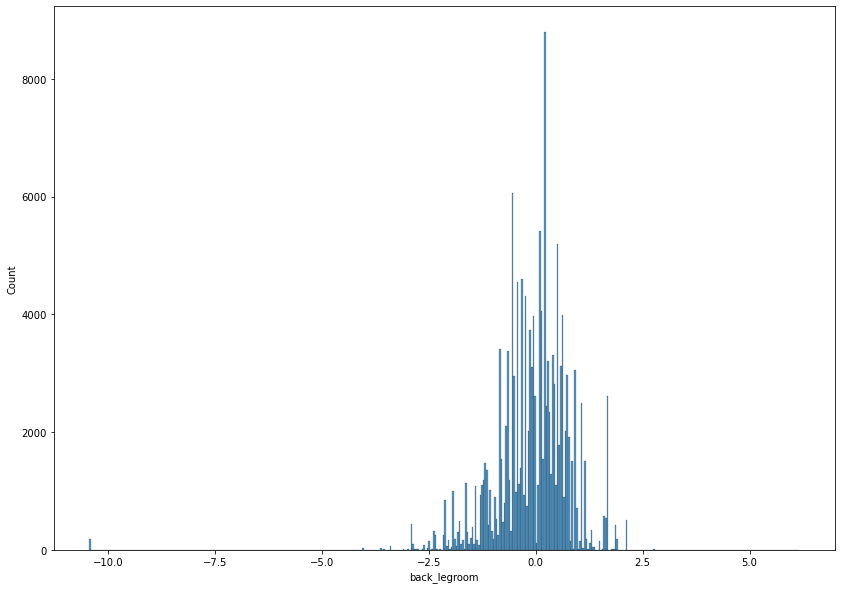

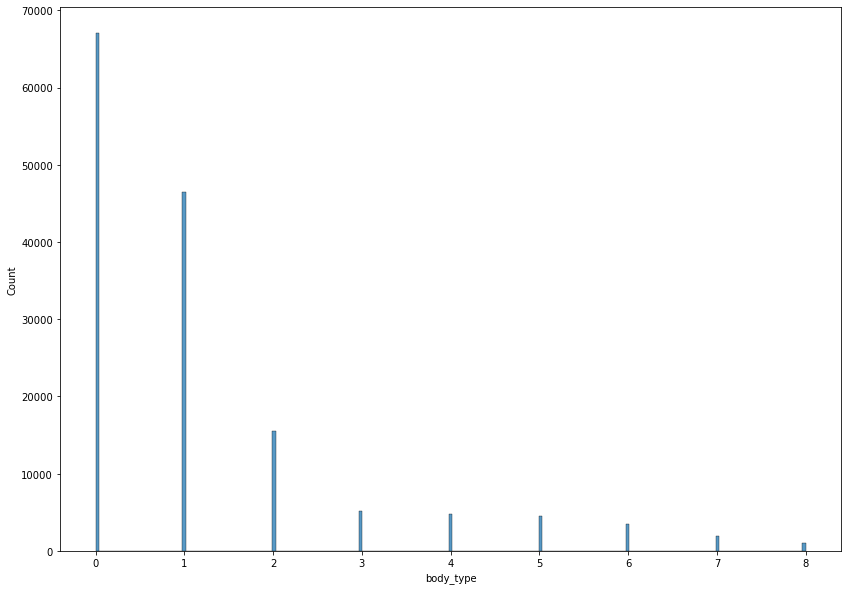

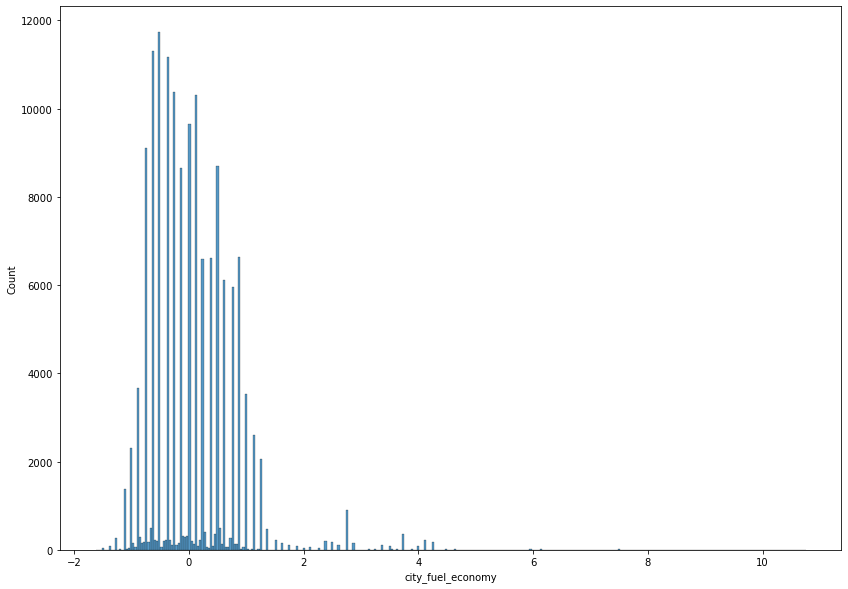

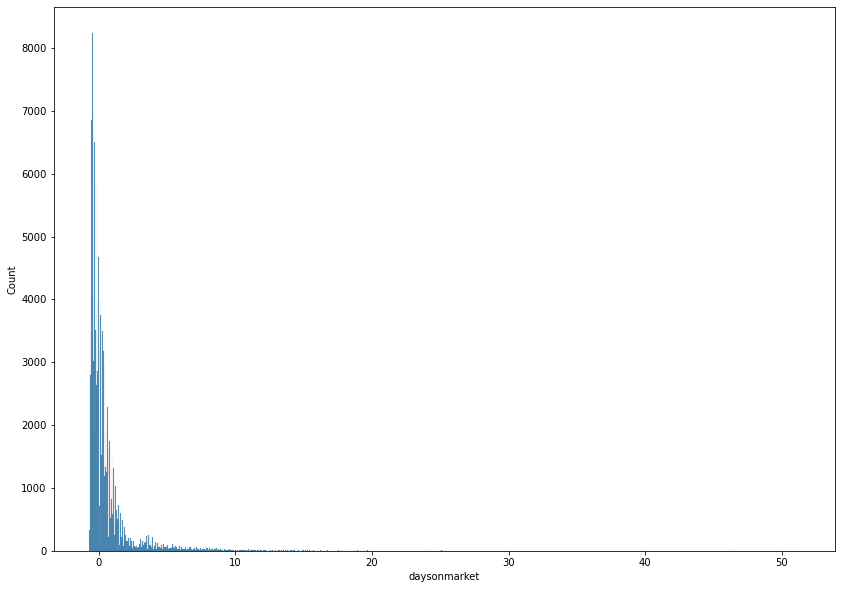

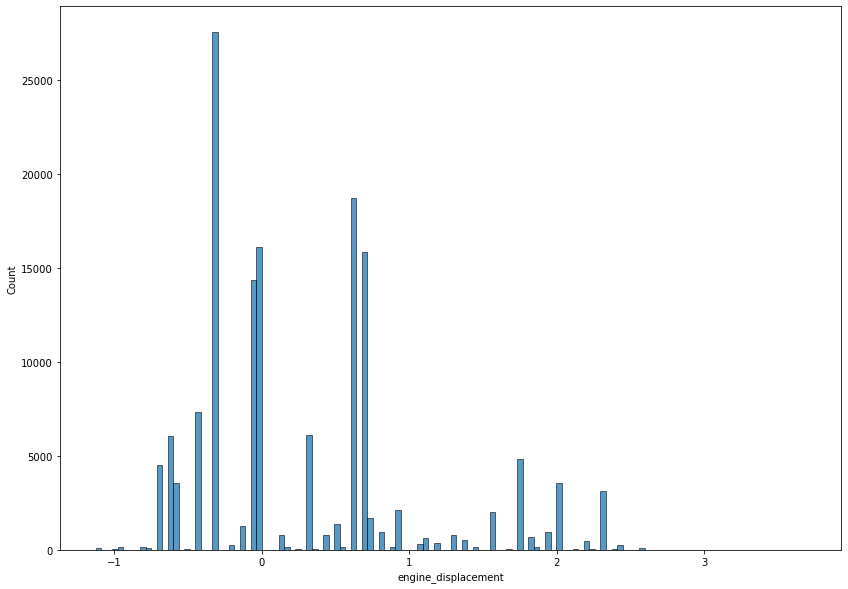

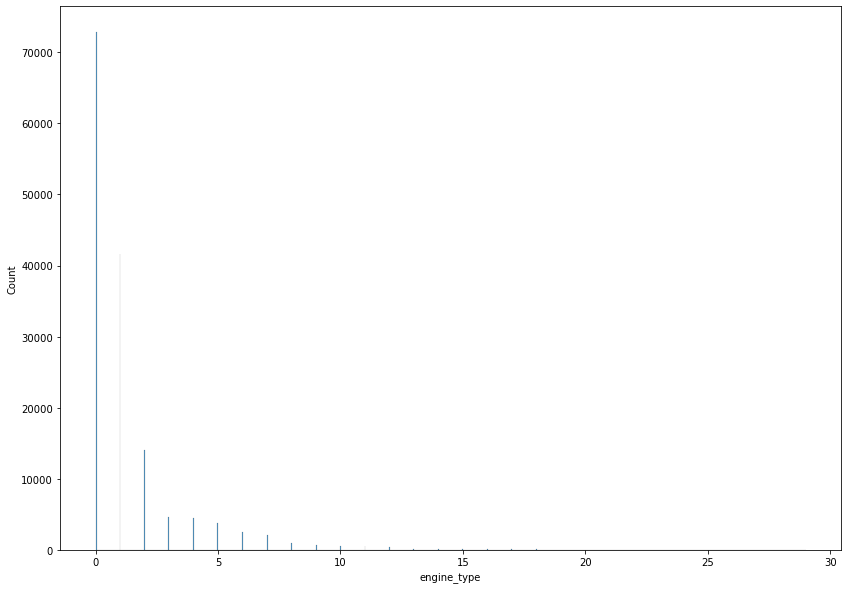

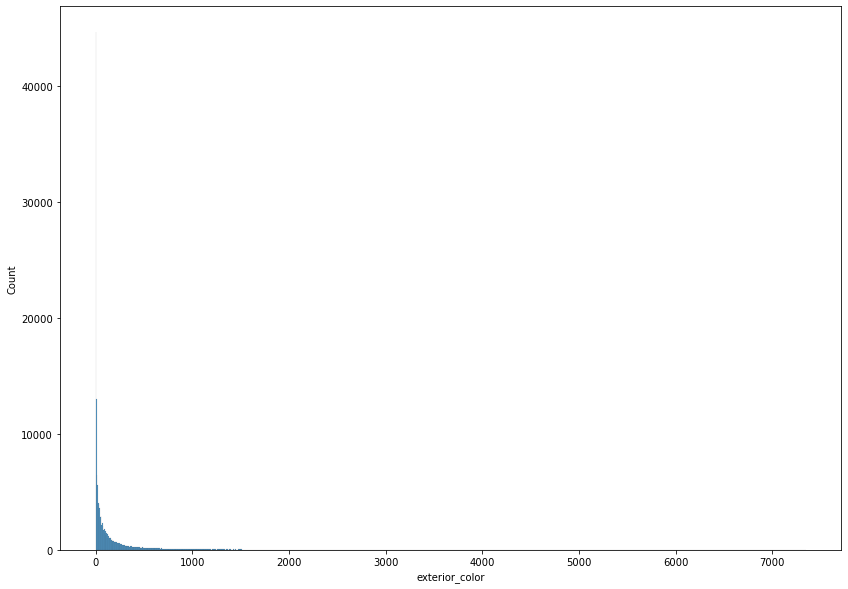

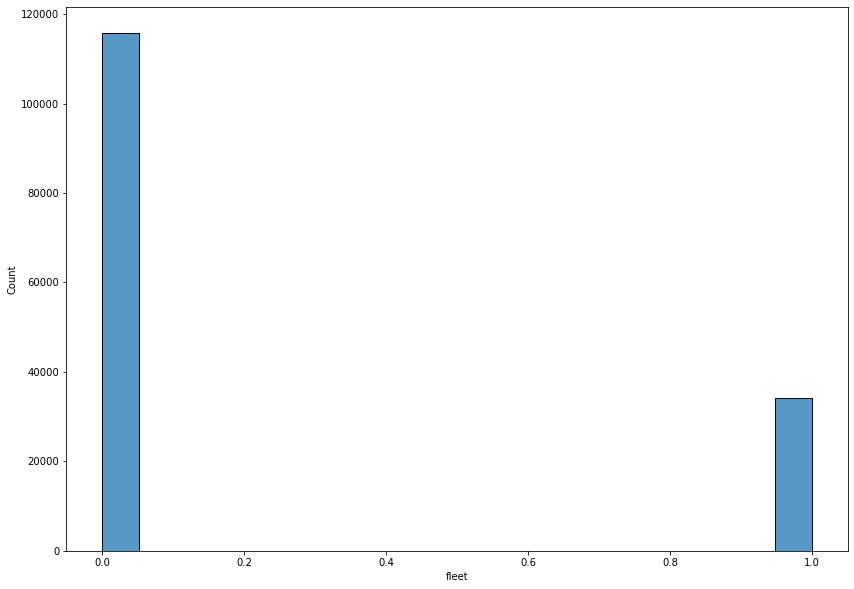

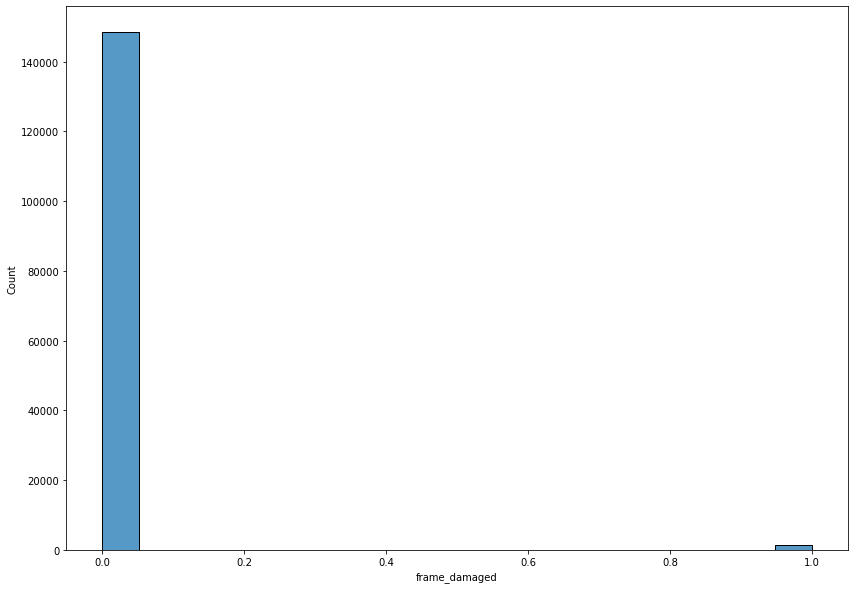

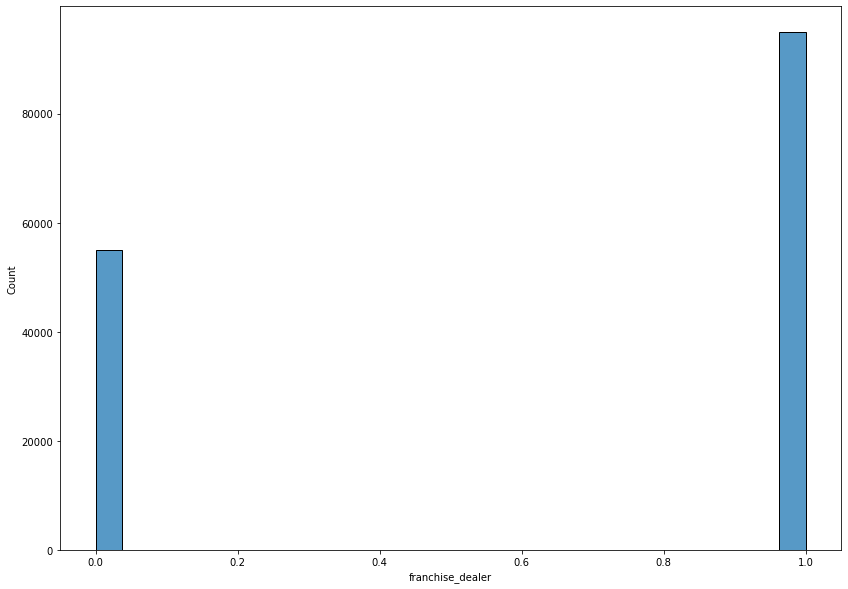

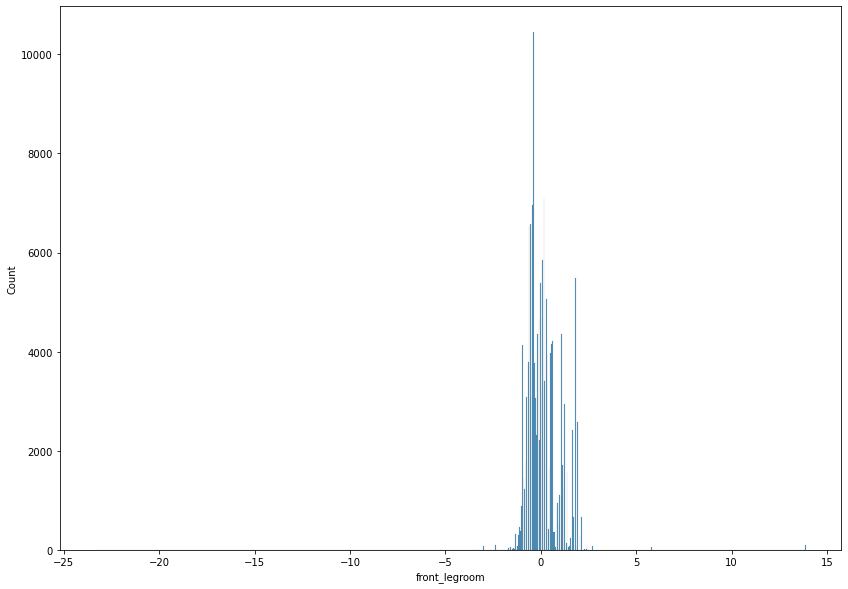

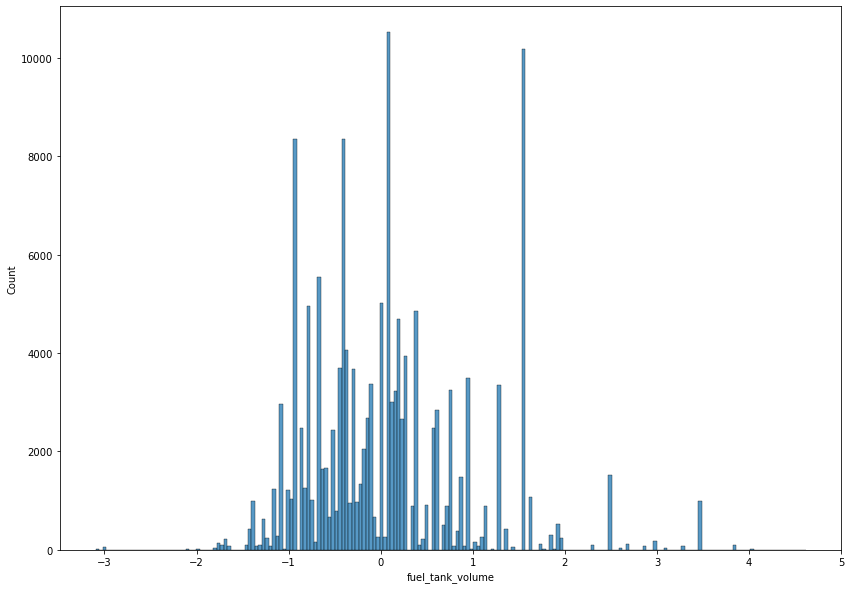

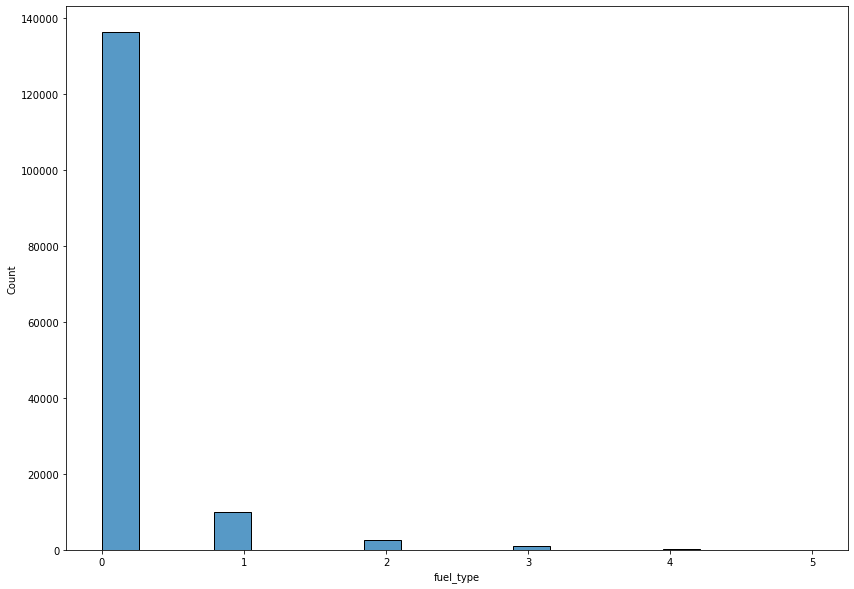

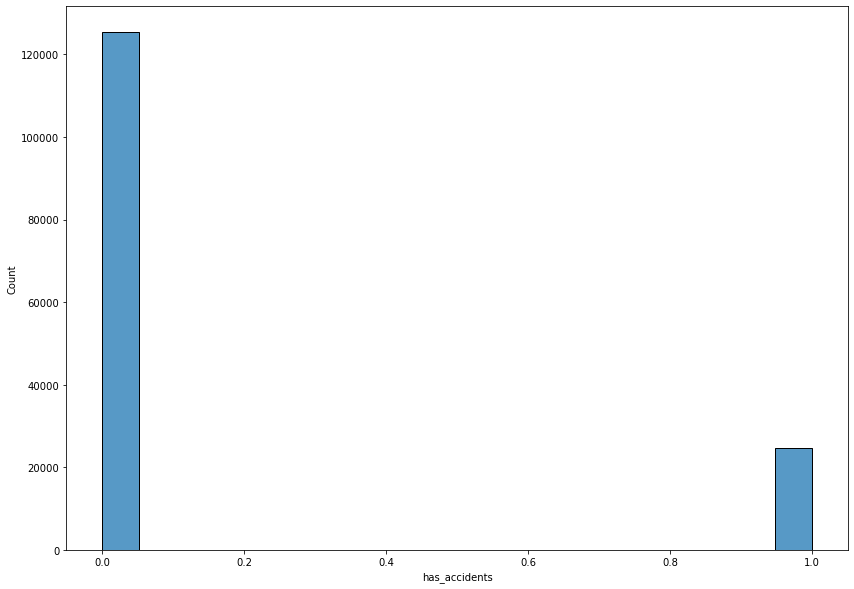

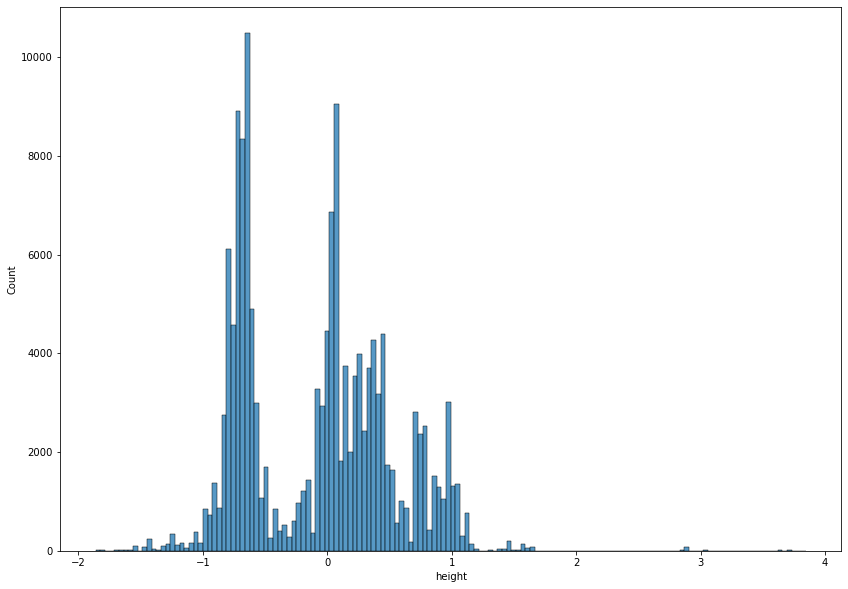

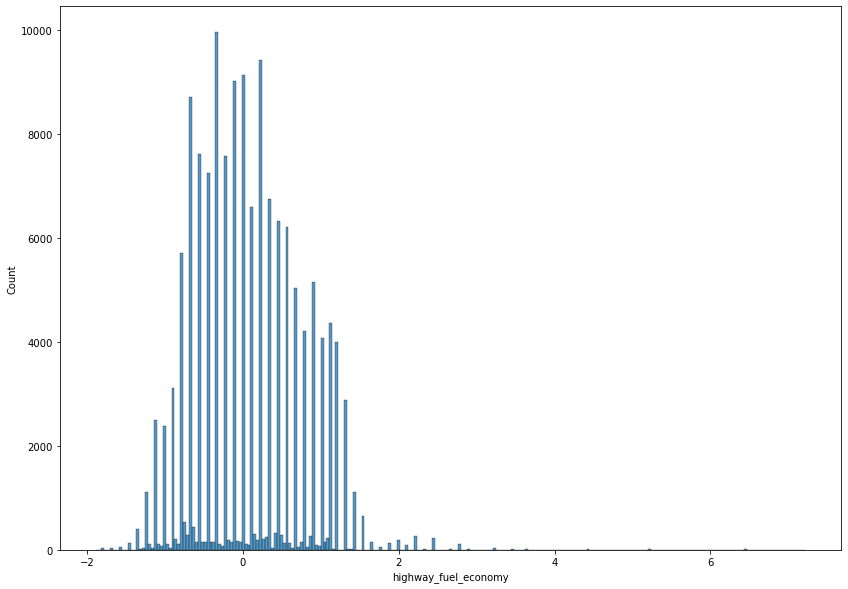

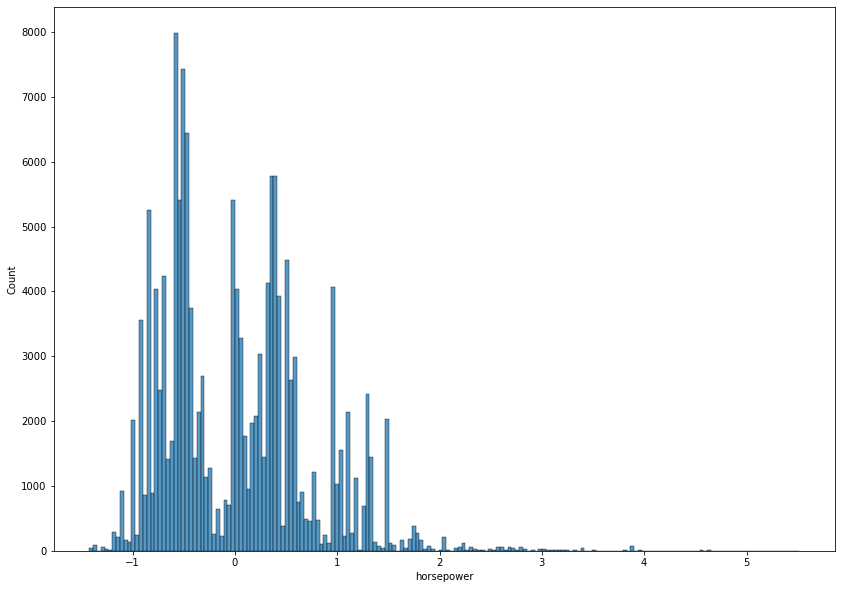

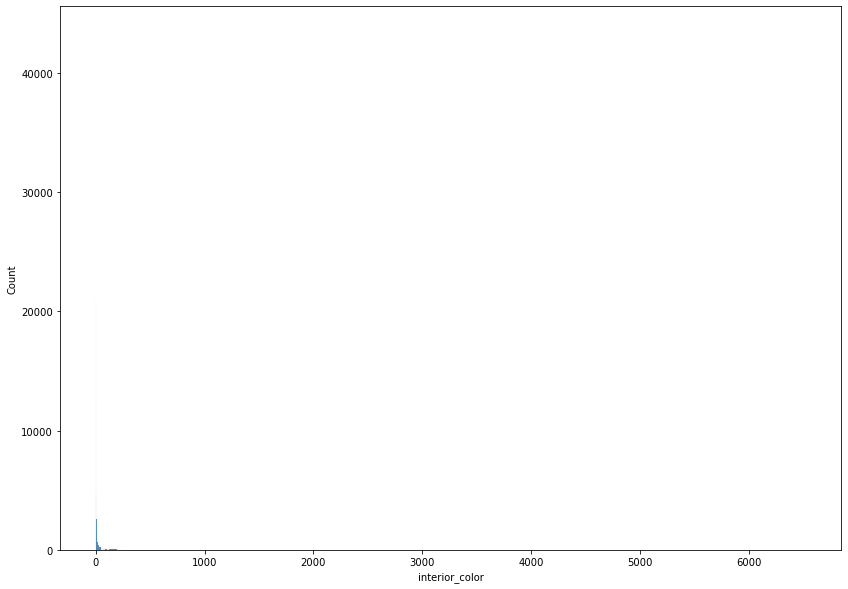

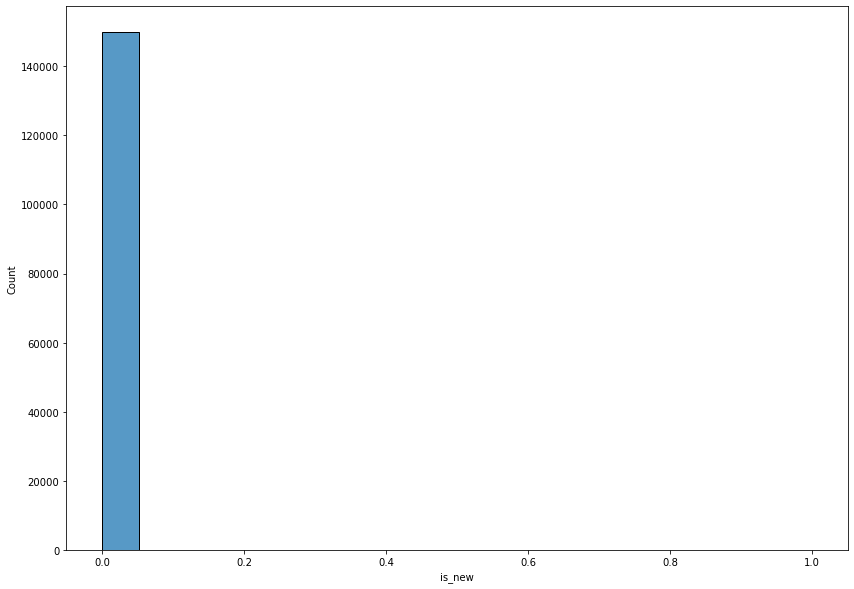

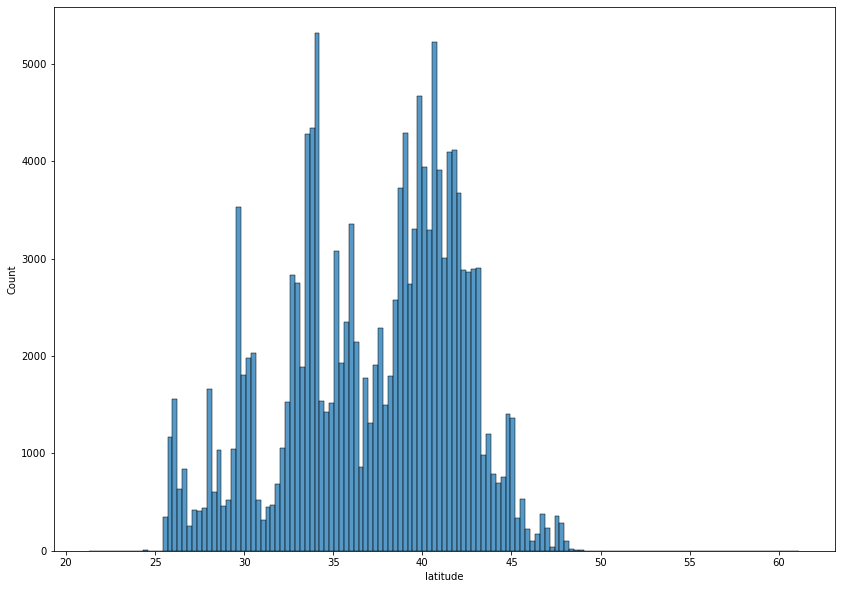

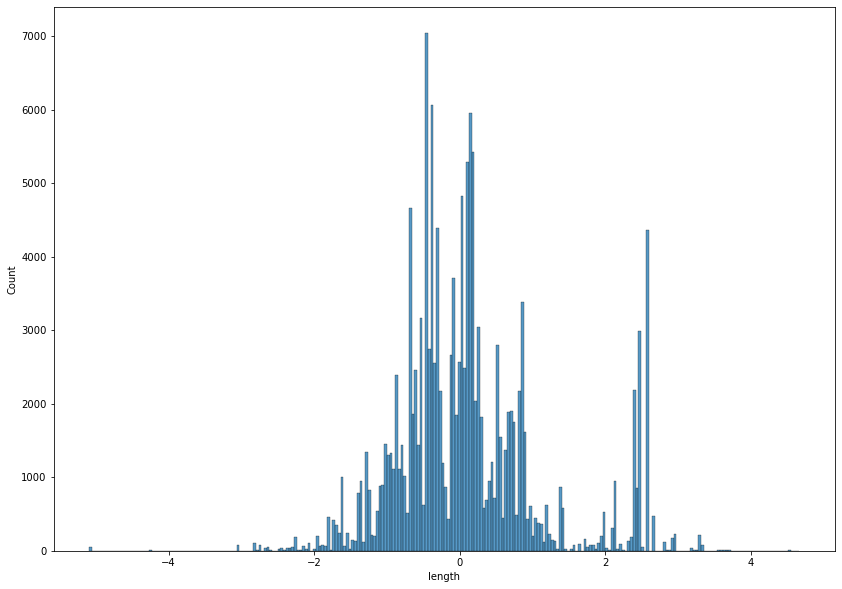

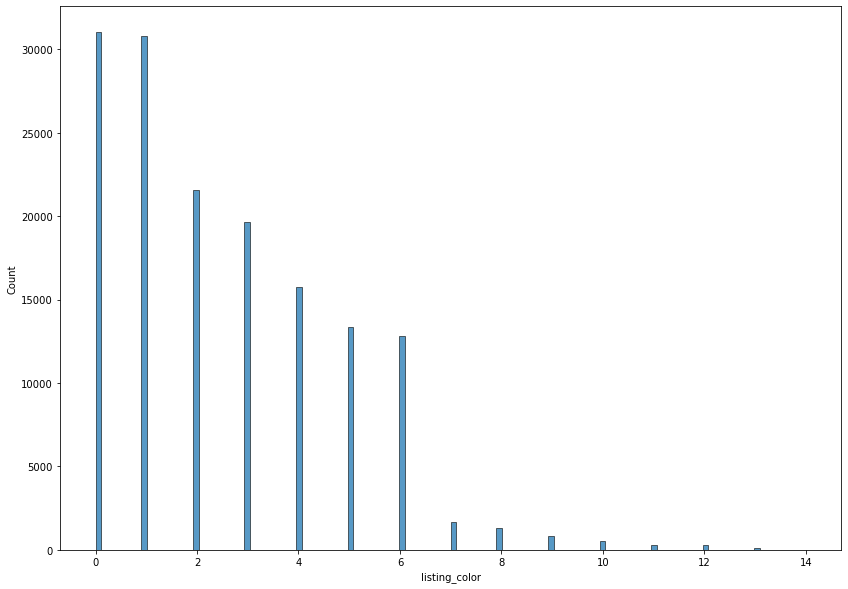

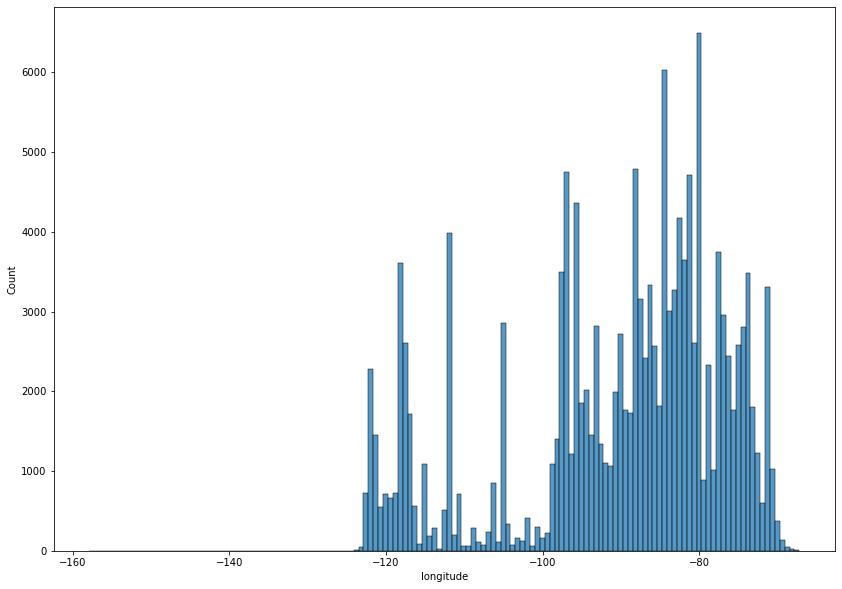

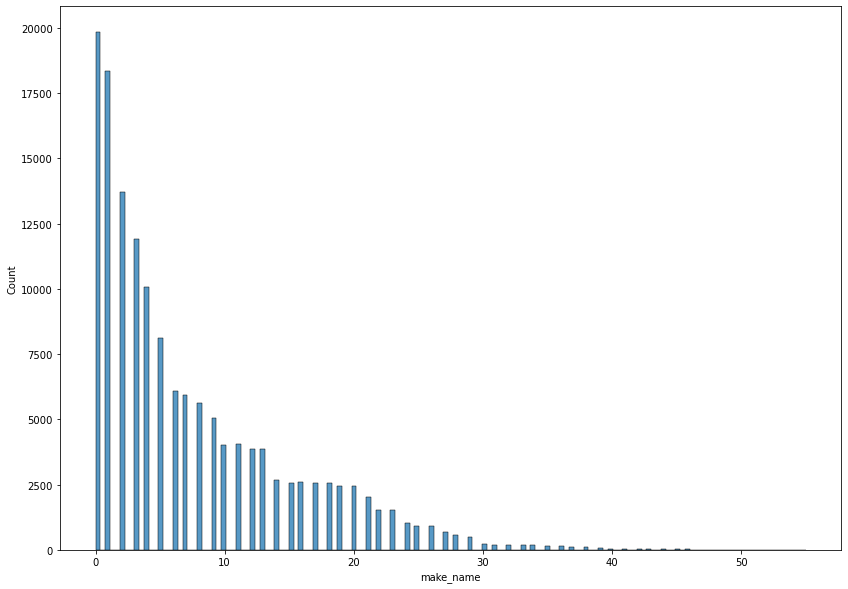

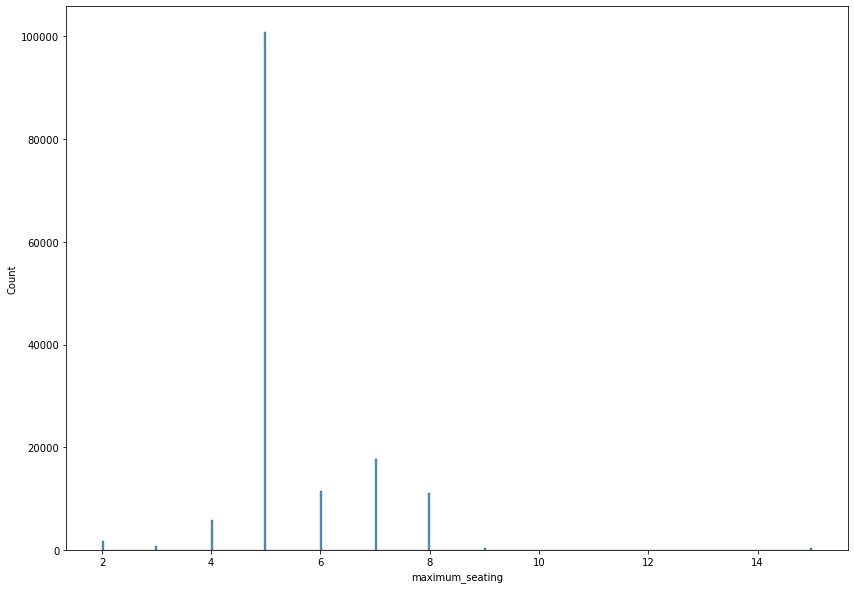

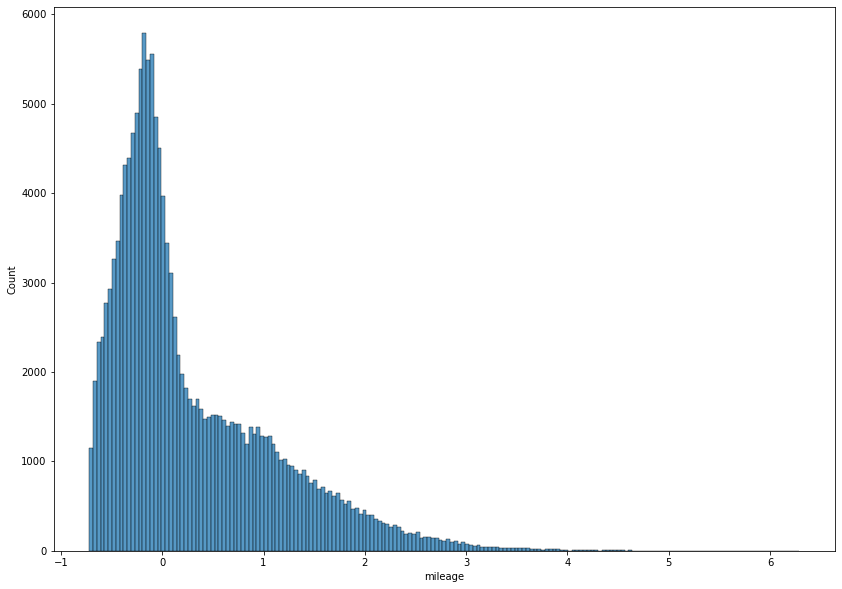

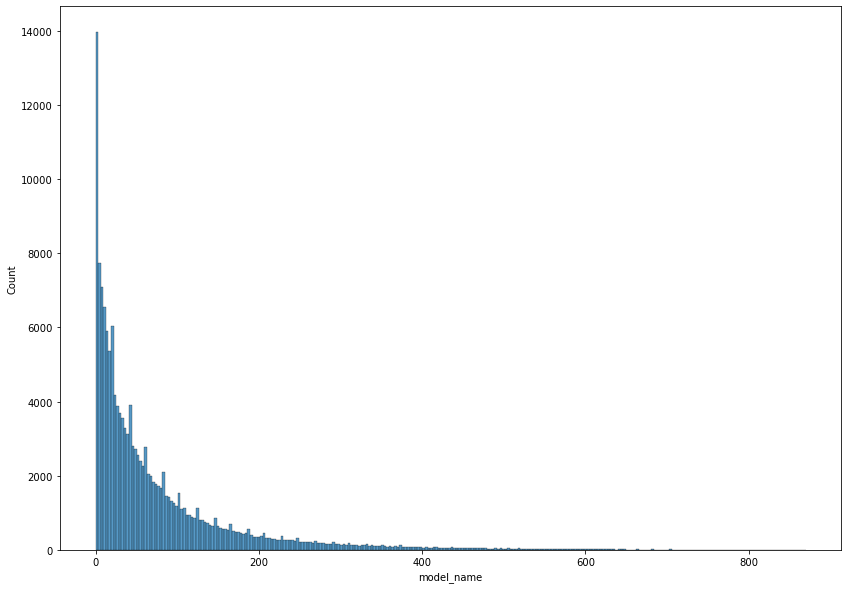

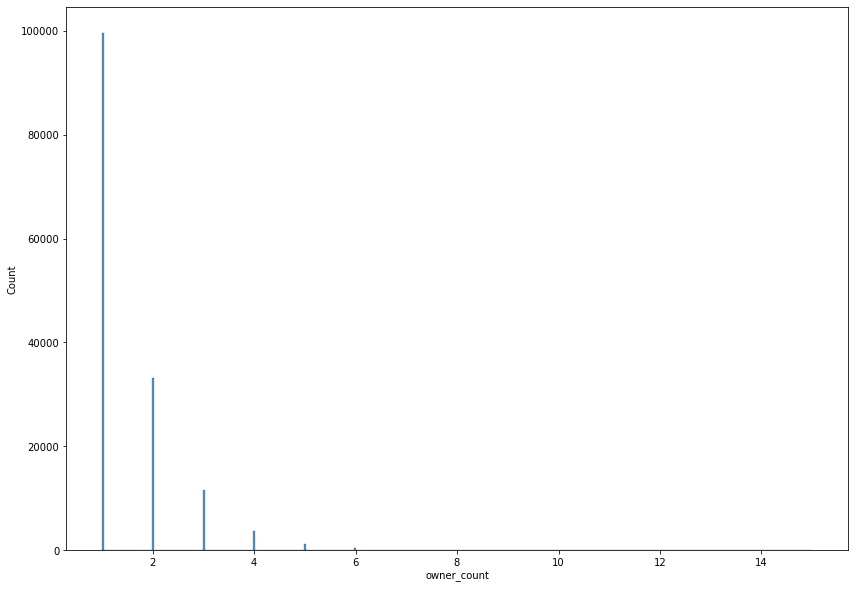

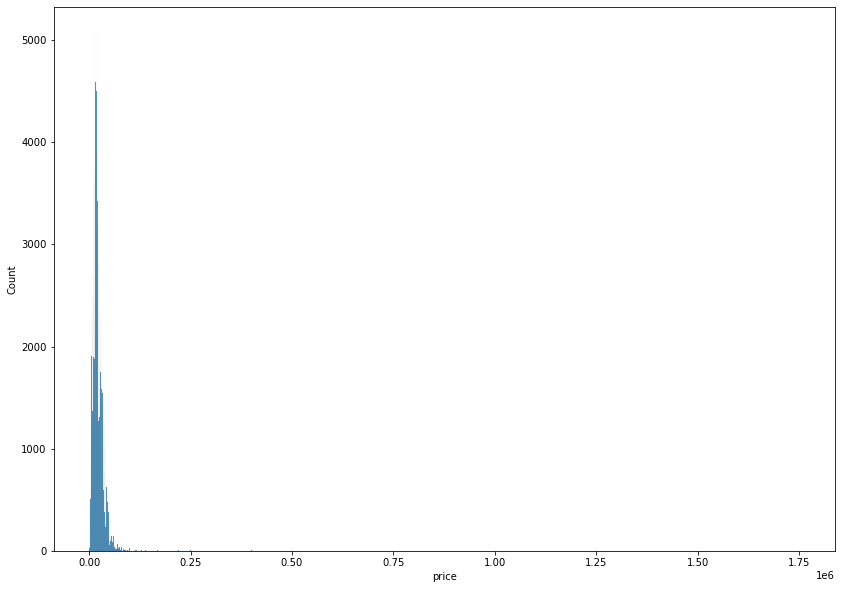

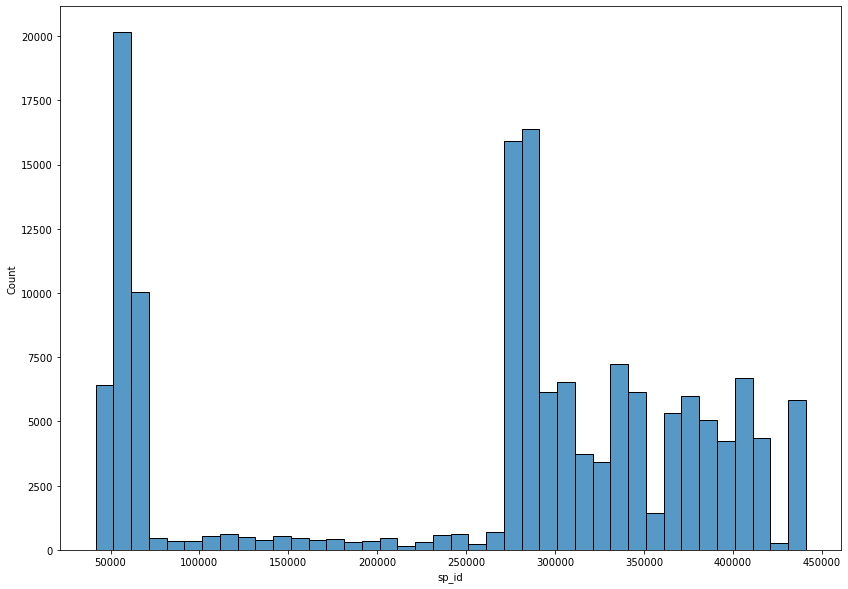

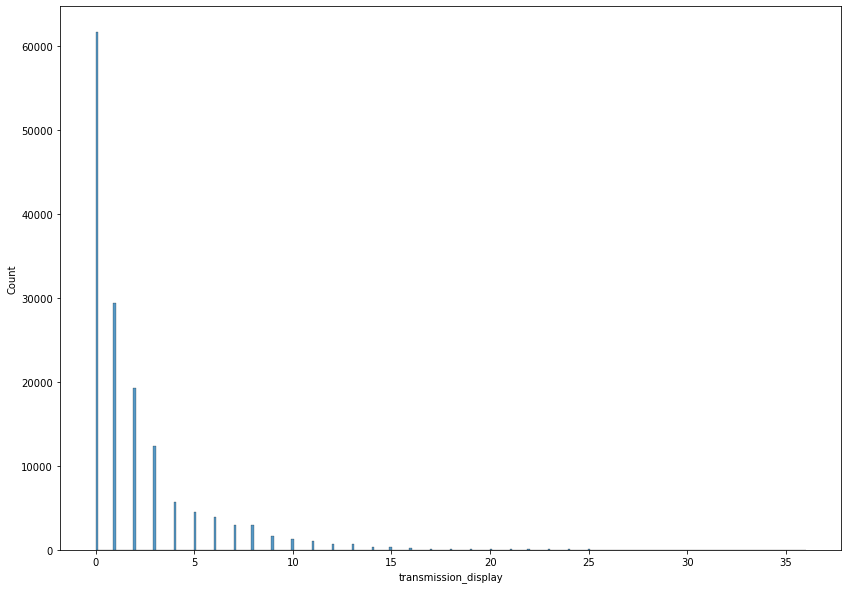

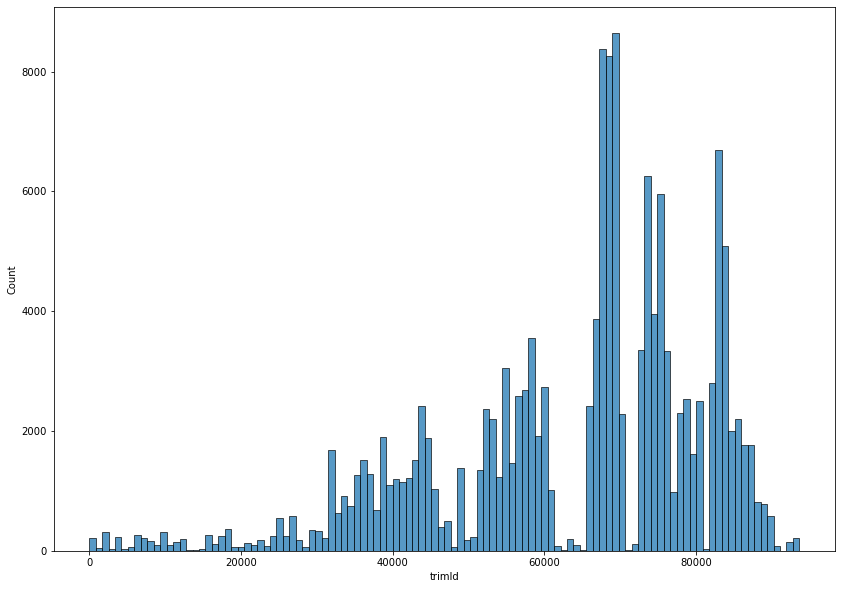

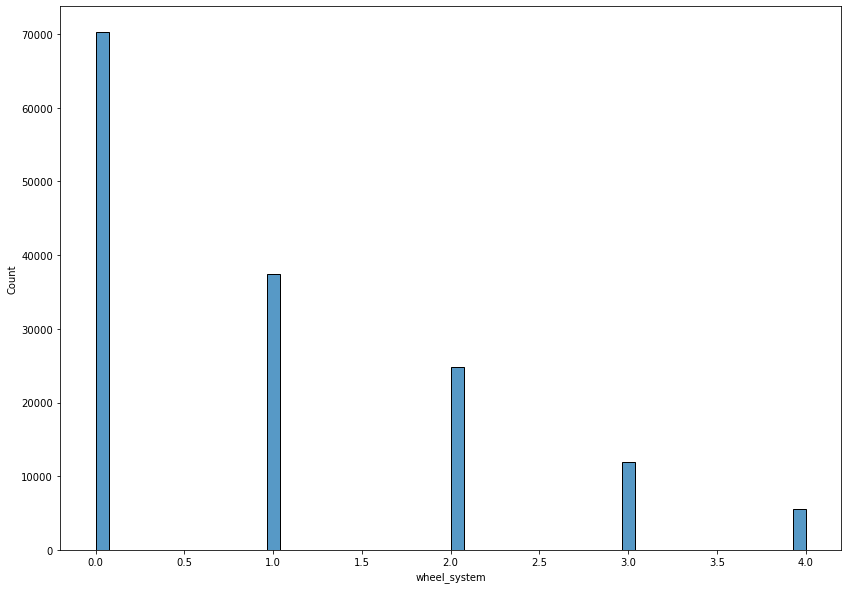

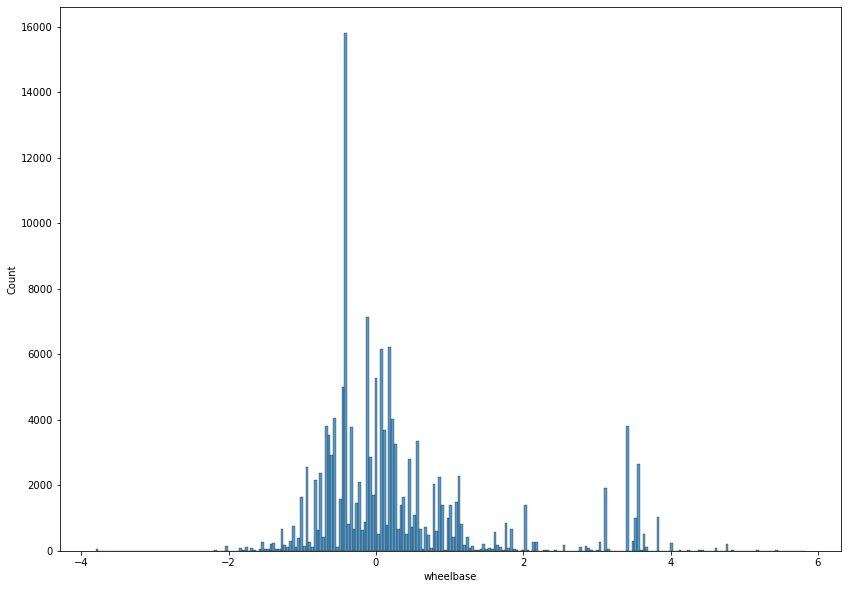

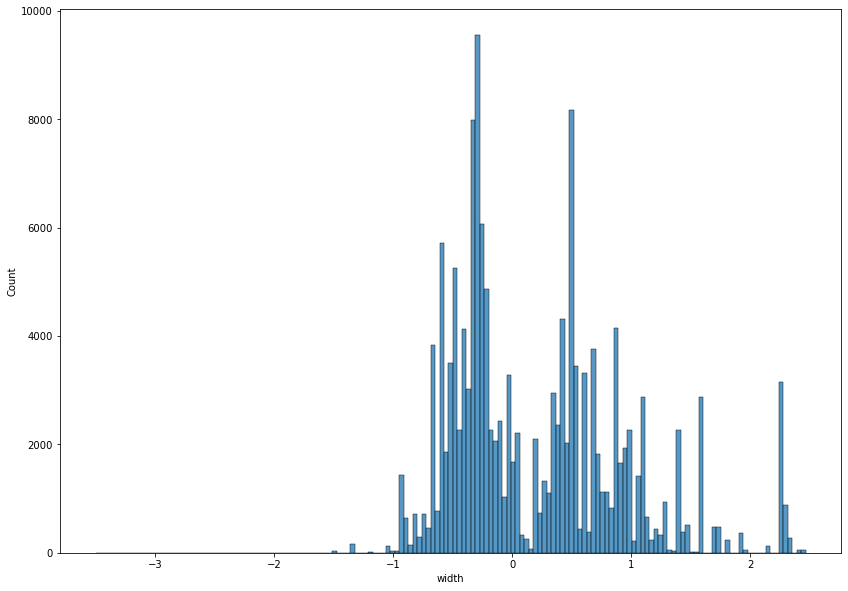

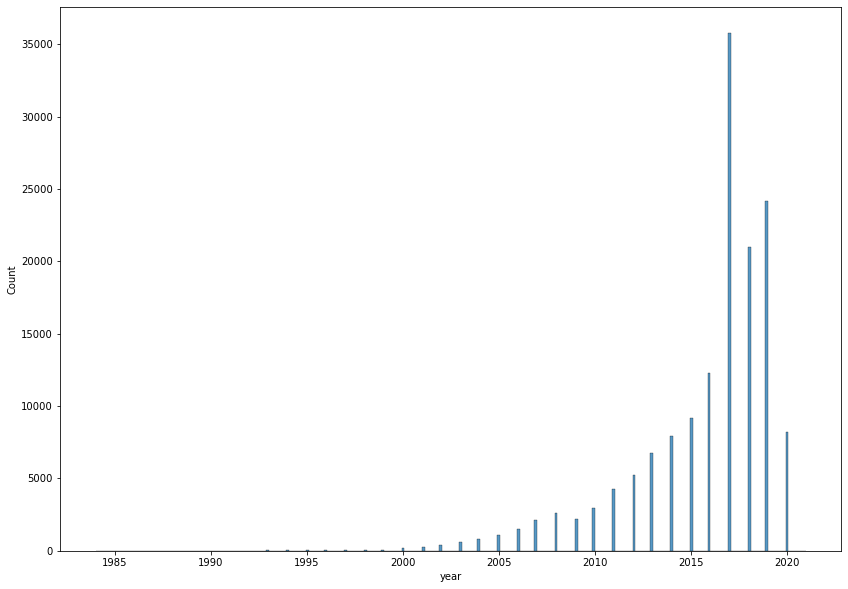

In [7]:
explore.get_distribution(train_scaled.drop(columns=['vin','city','dealer_zip']))

### Target = Price

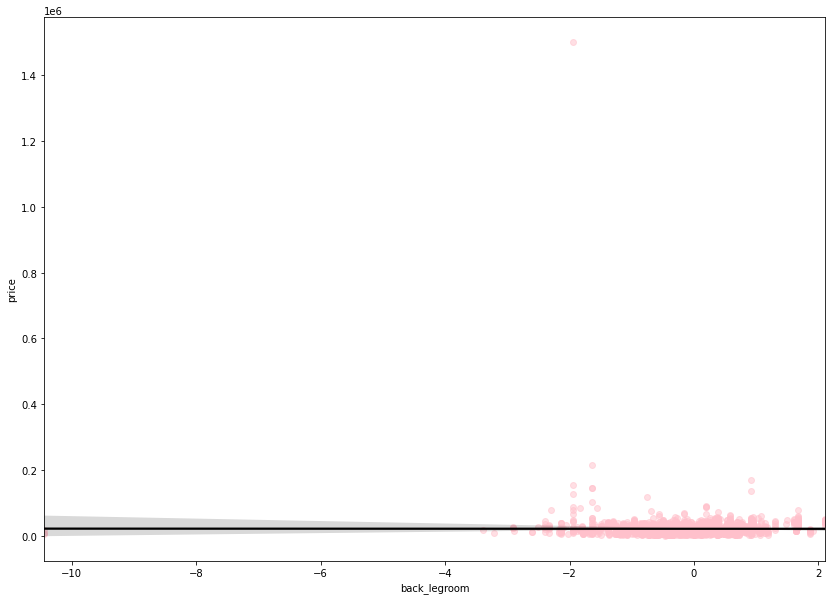

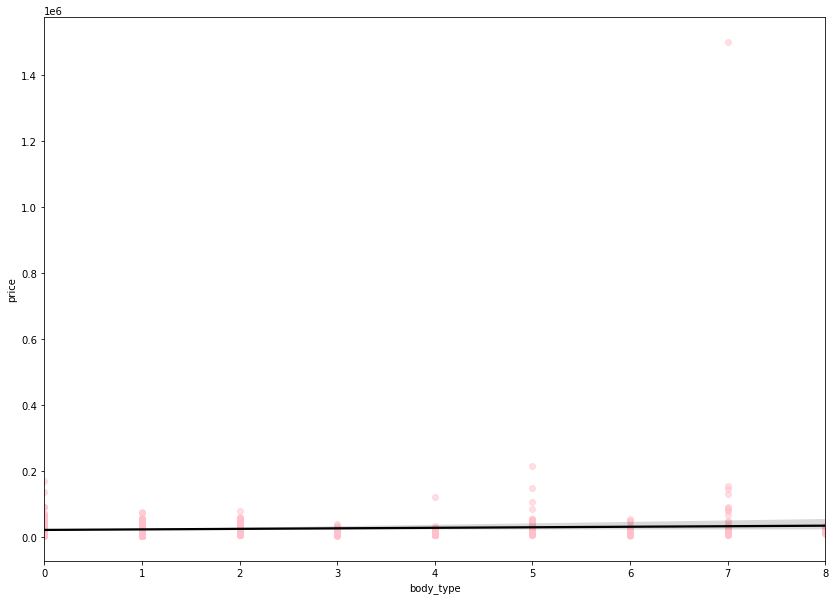

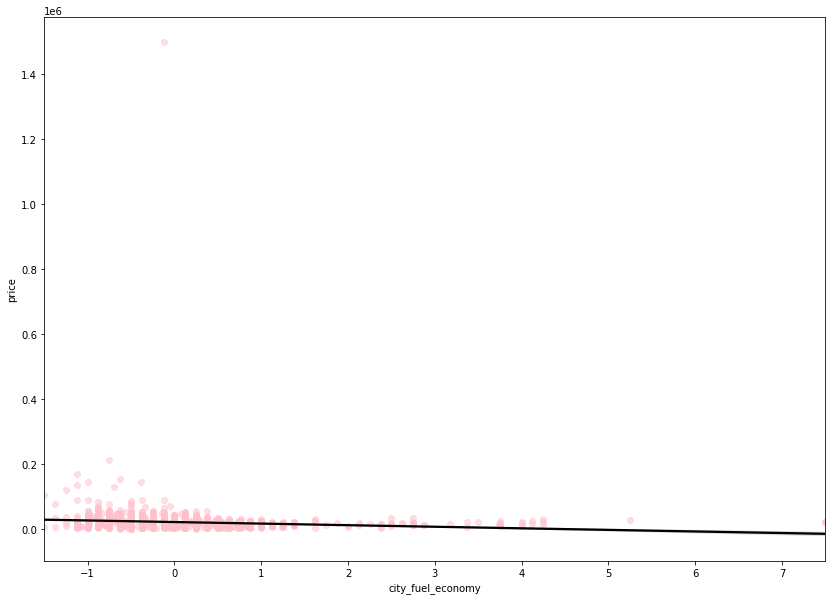

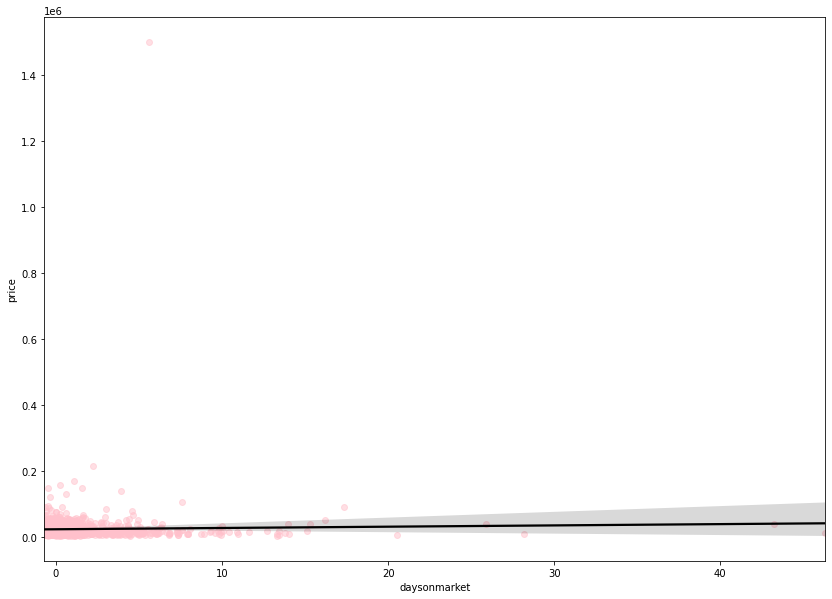

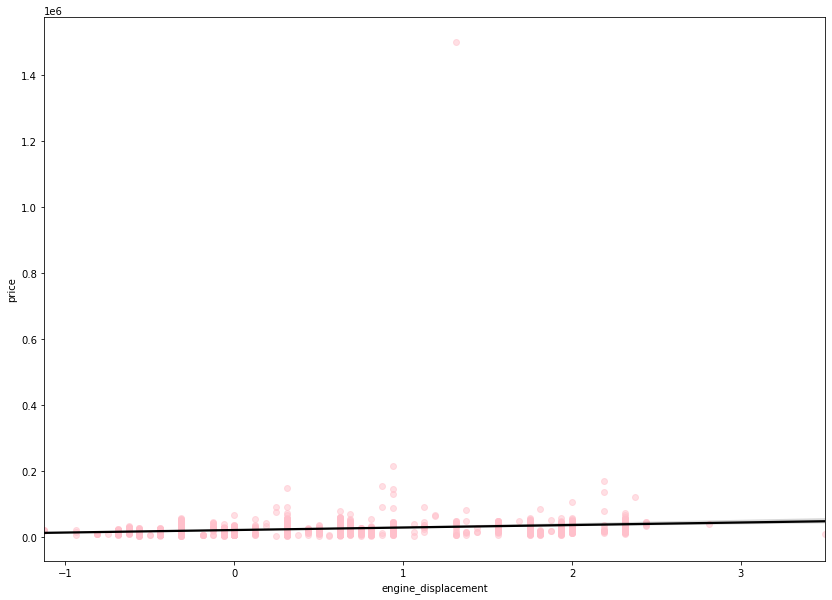

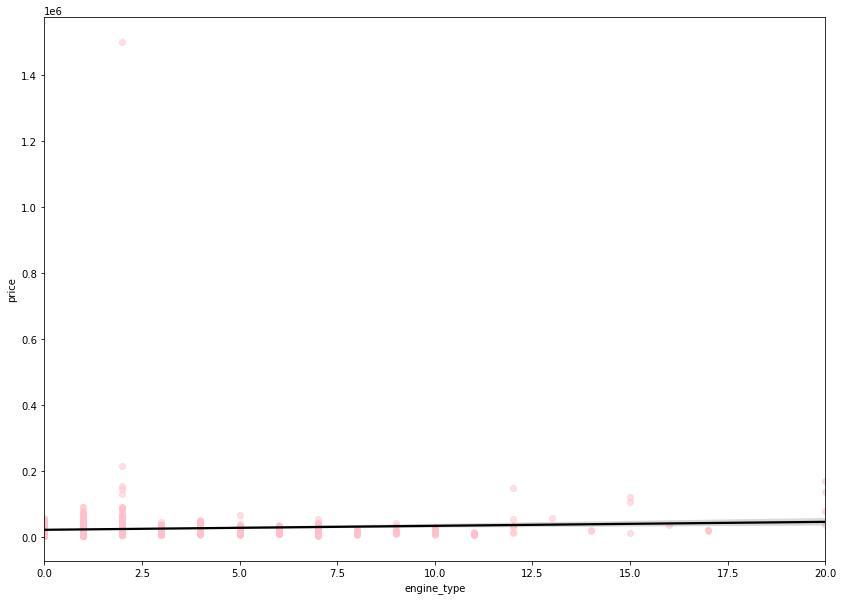

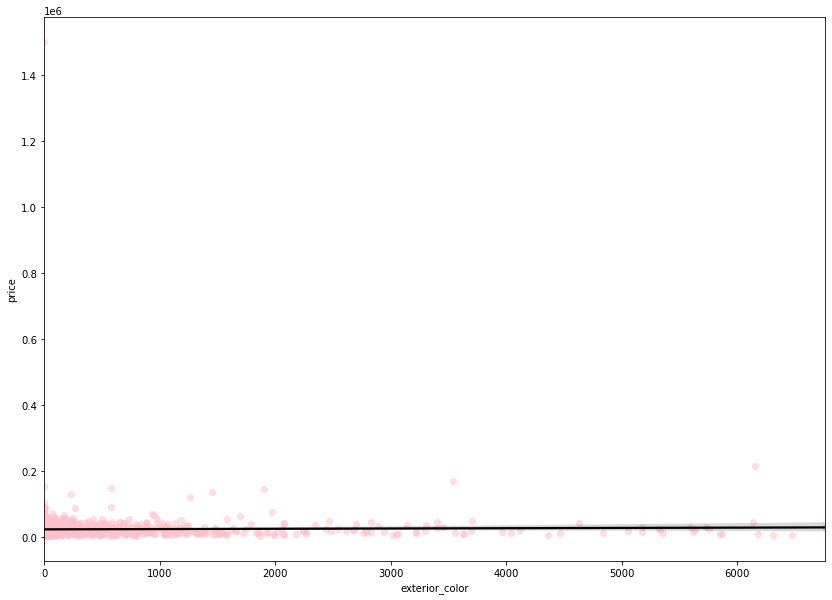

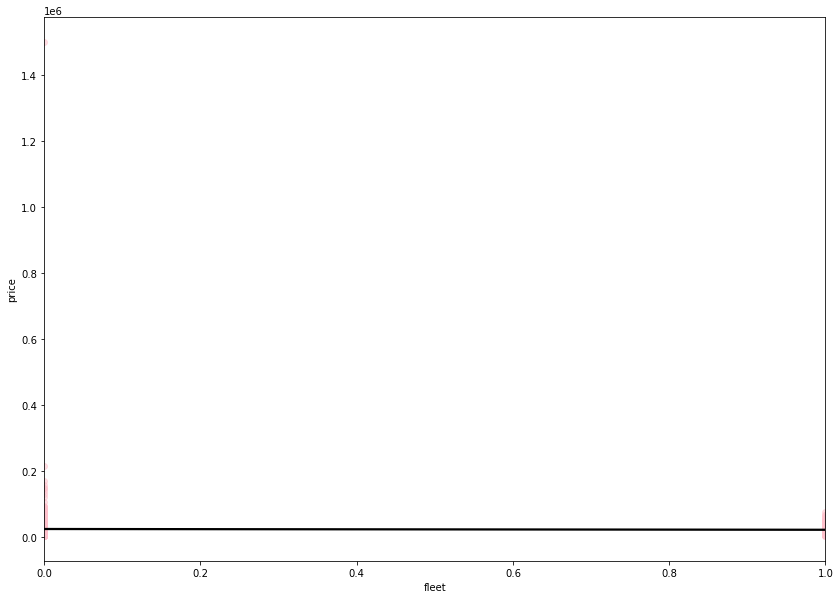

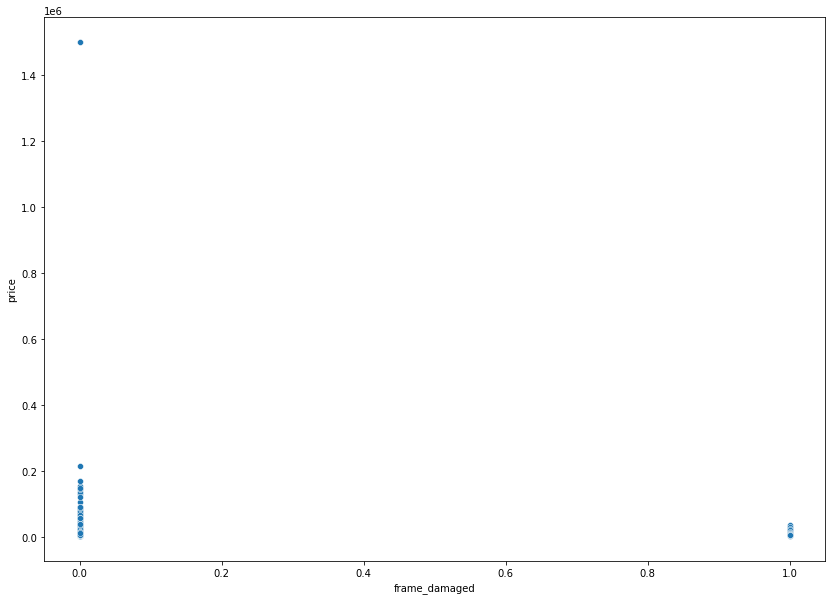

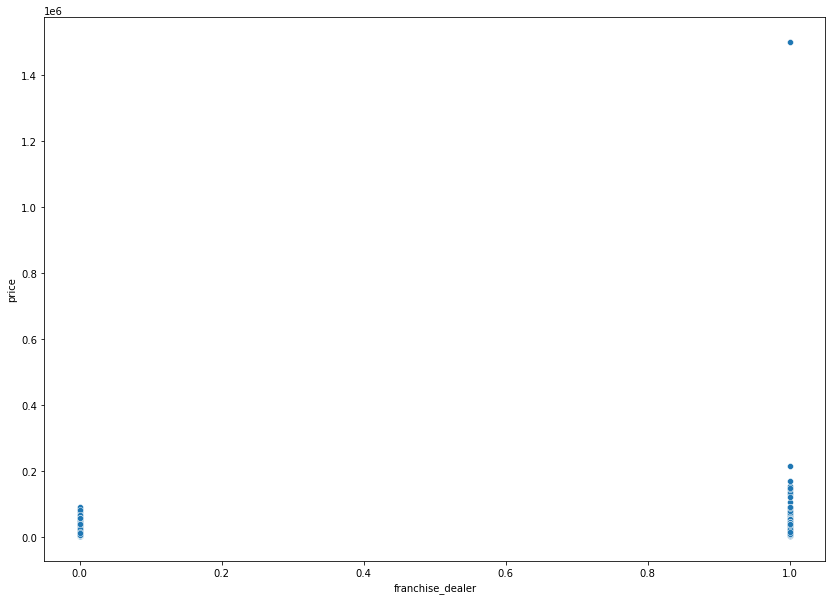

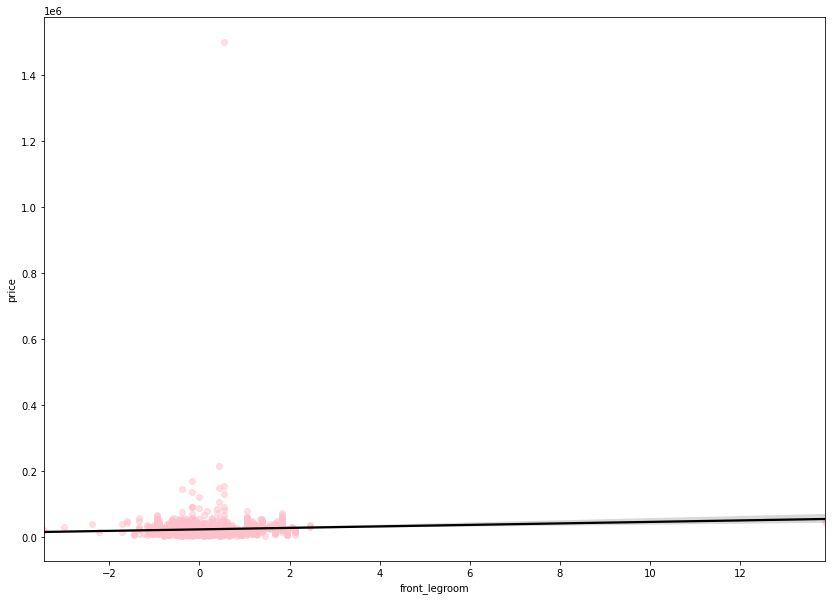

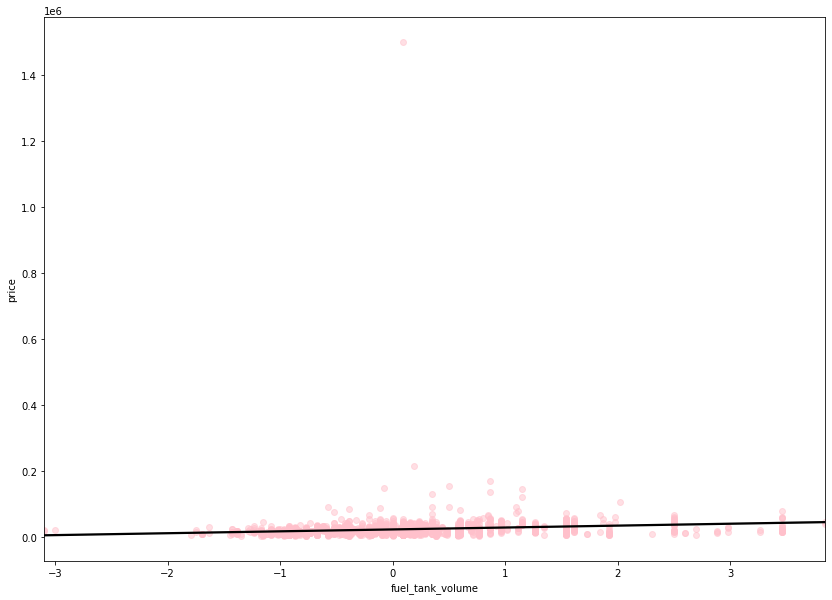

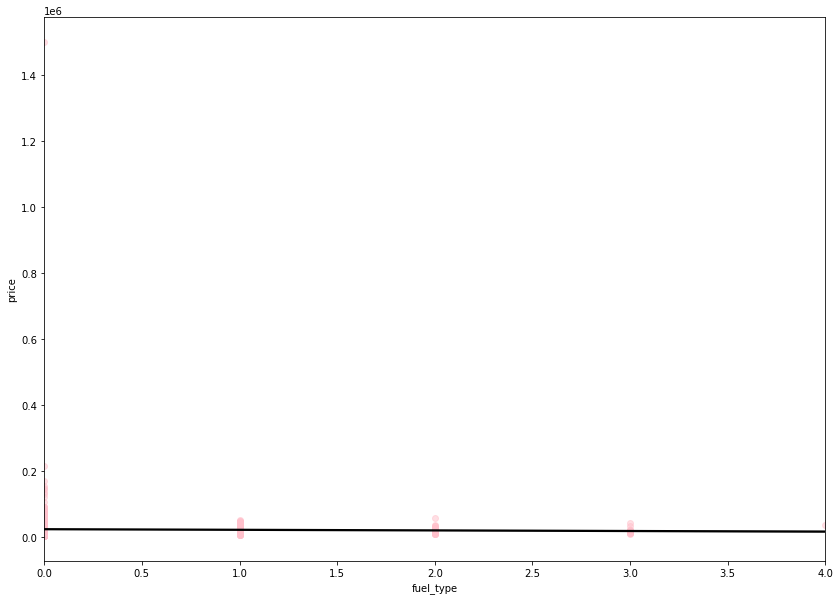

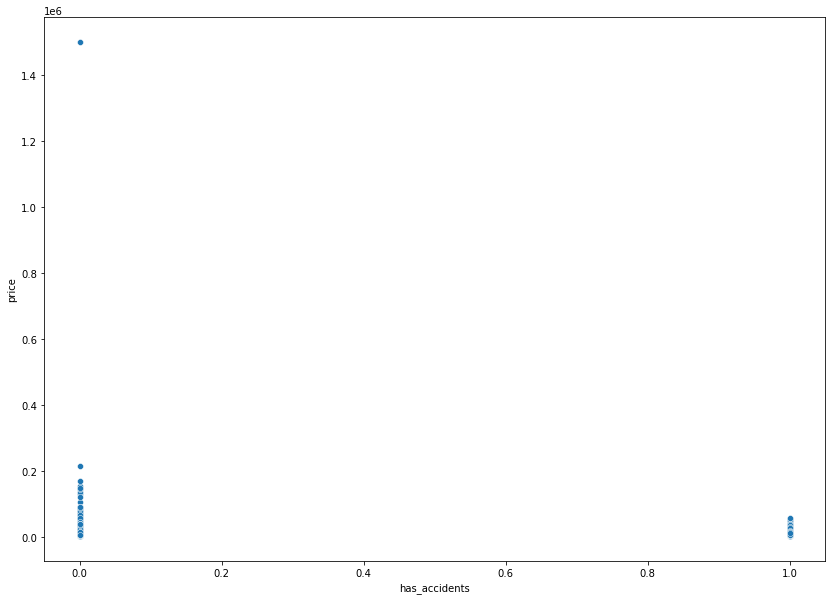

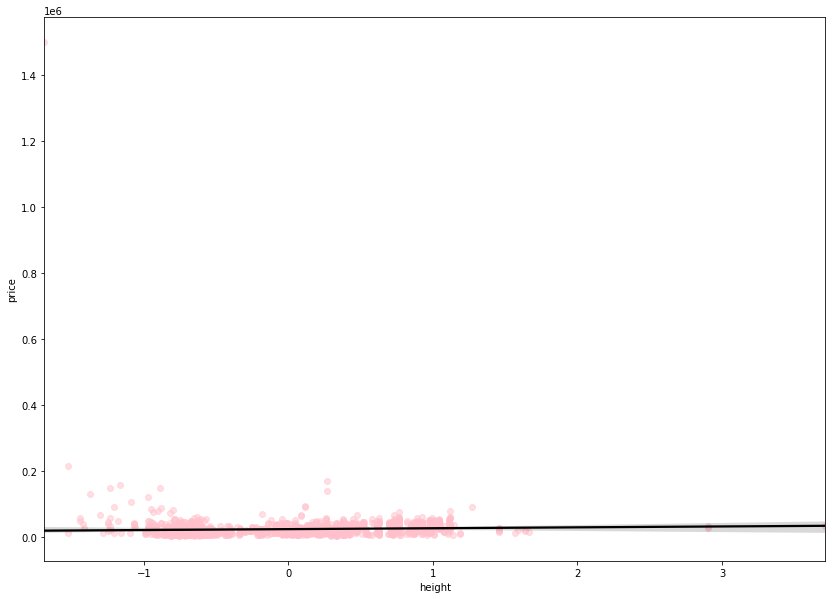

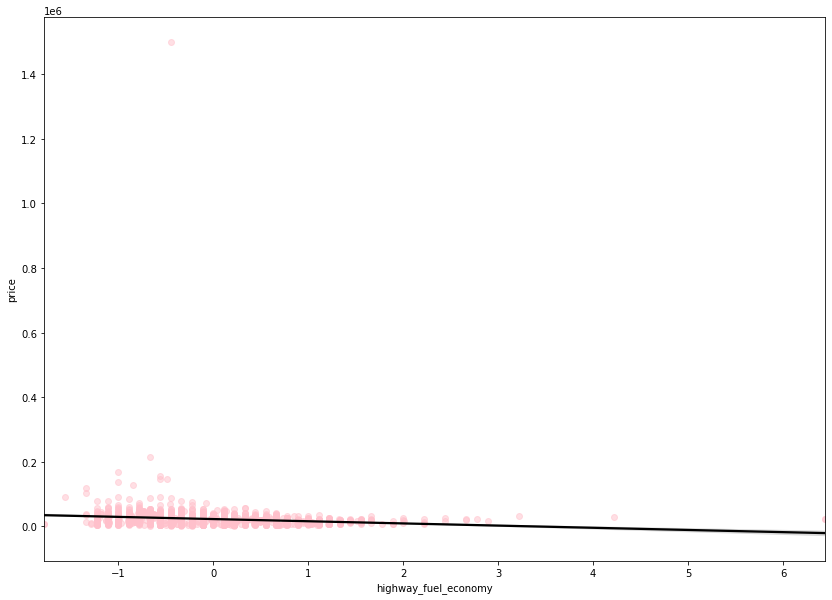

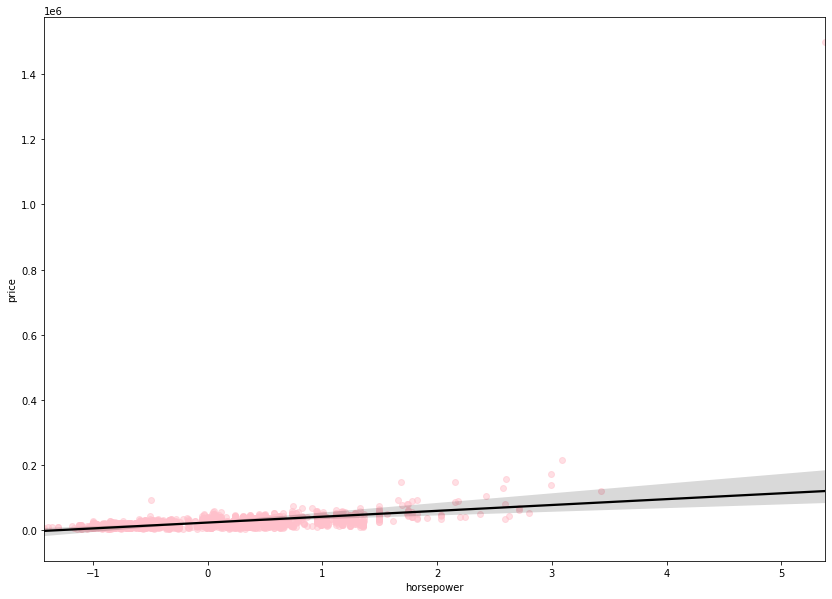

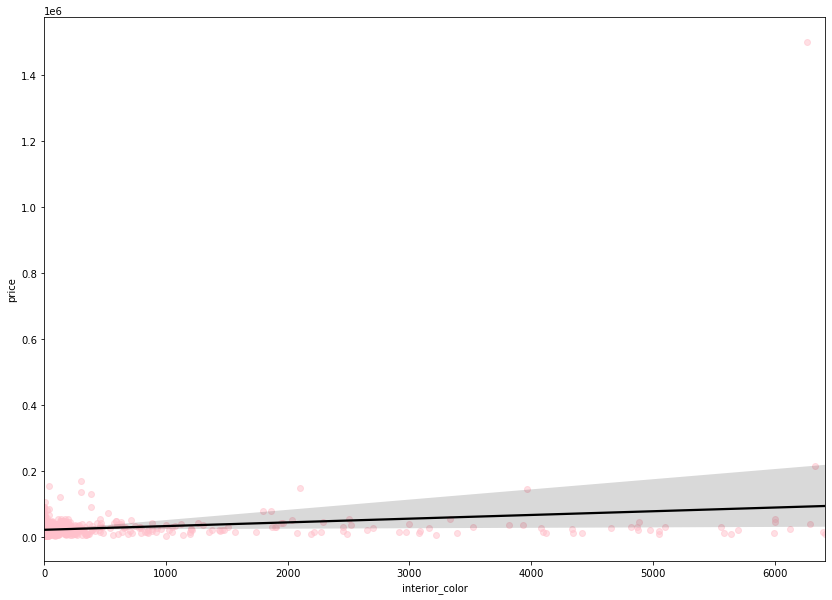

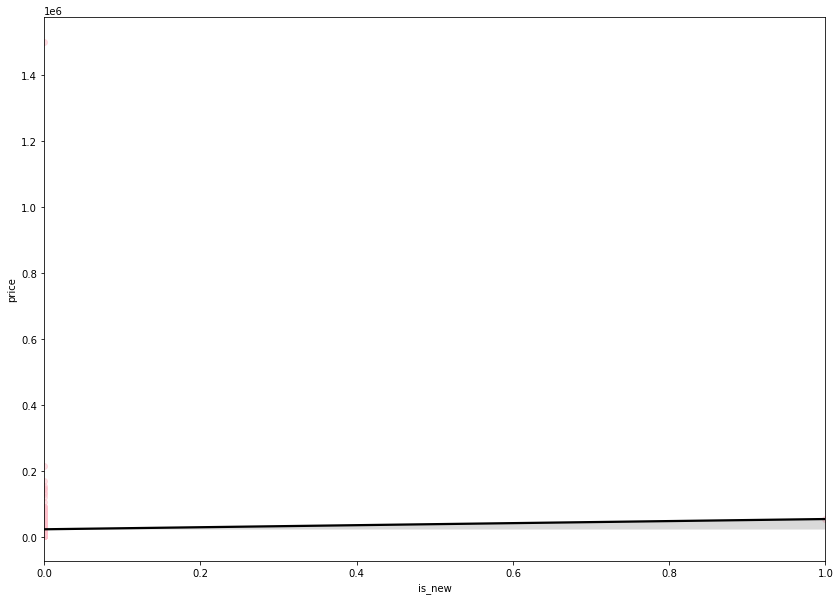

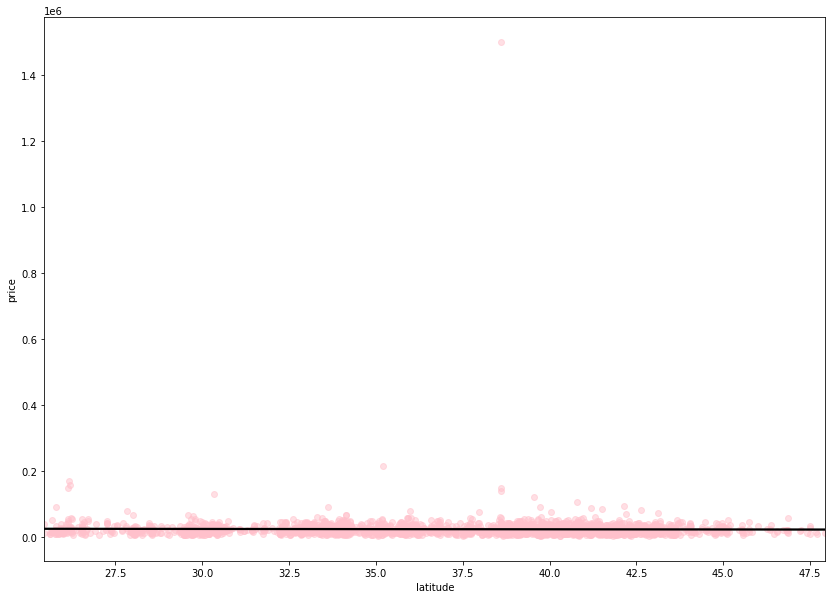

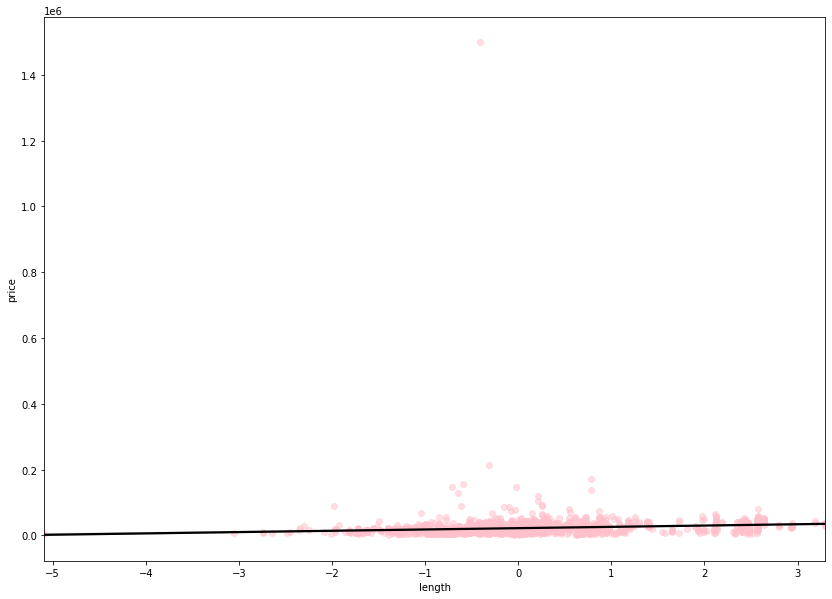

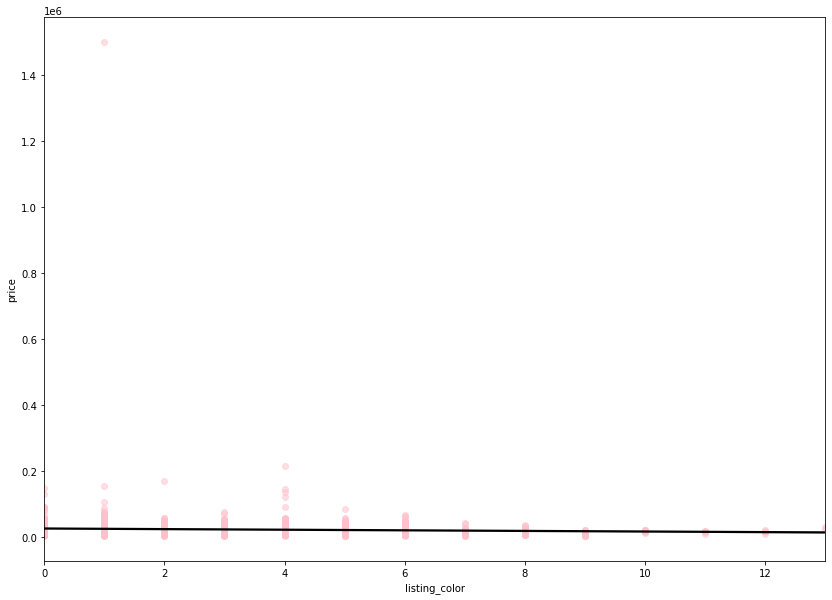

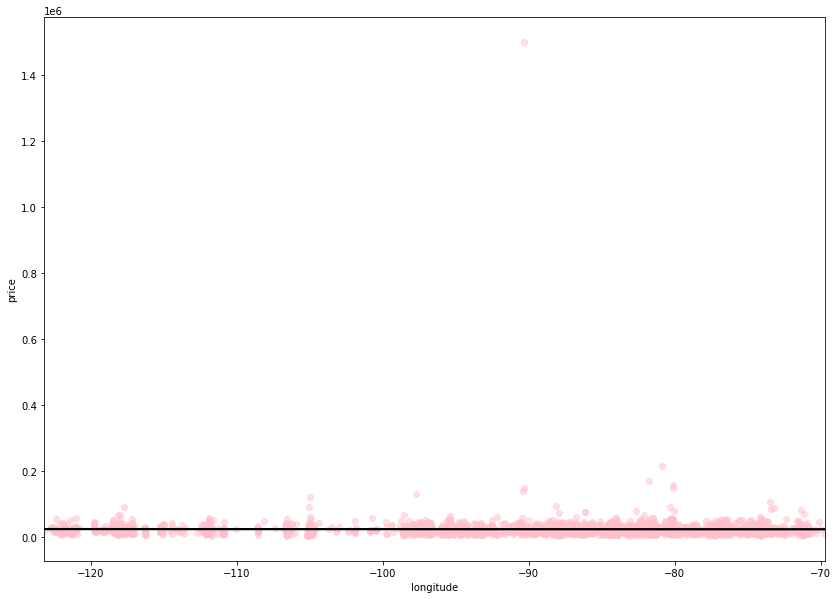

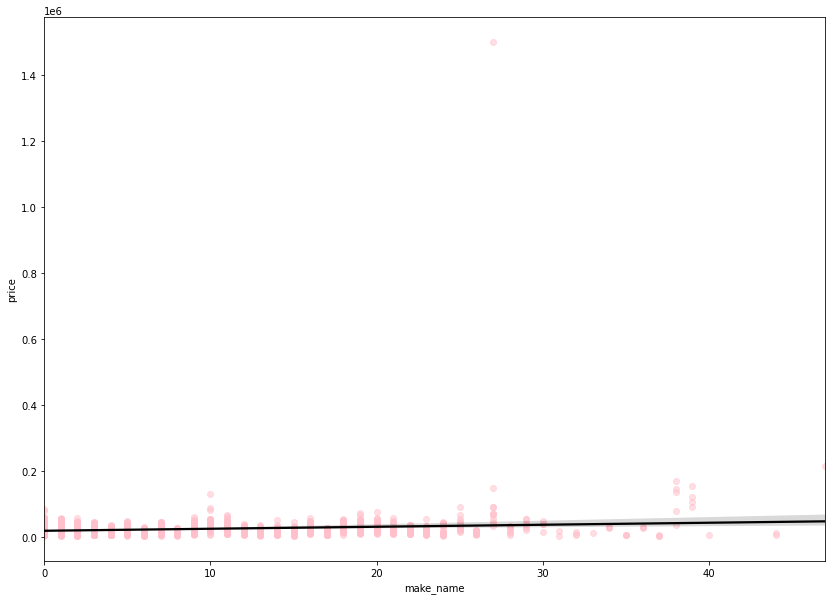

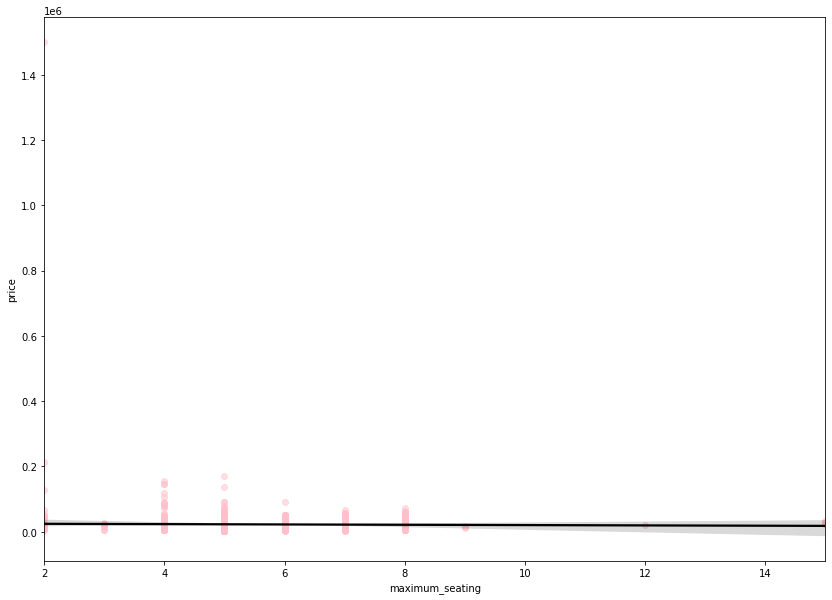

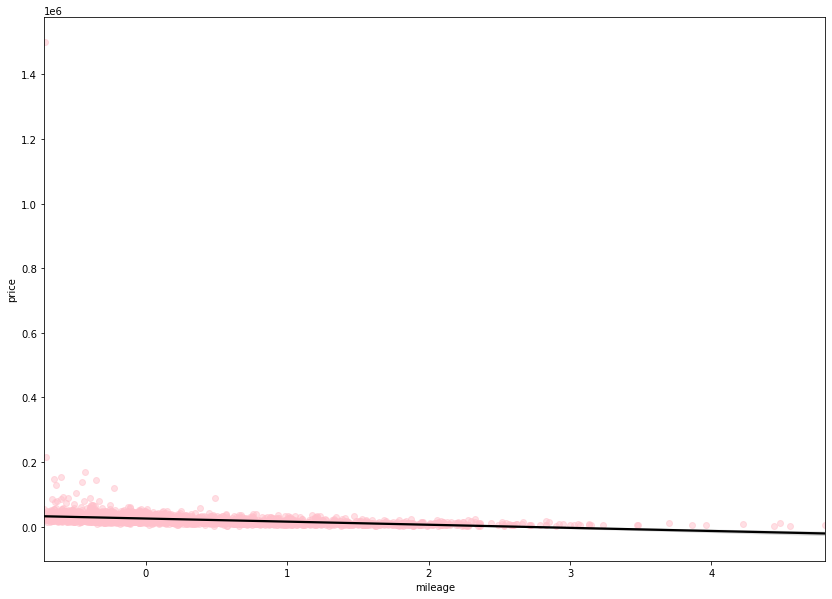

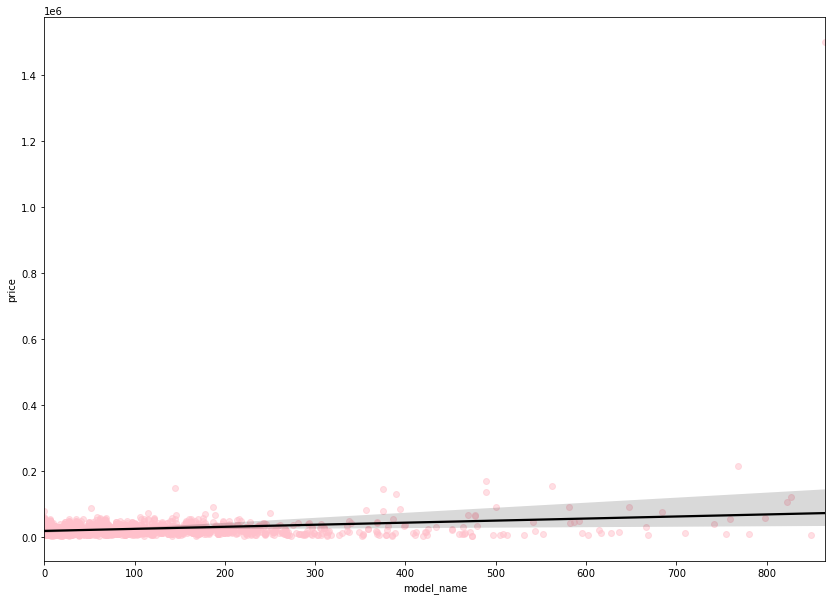

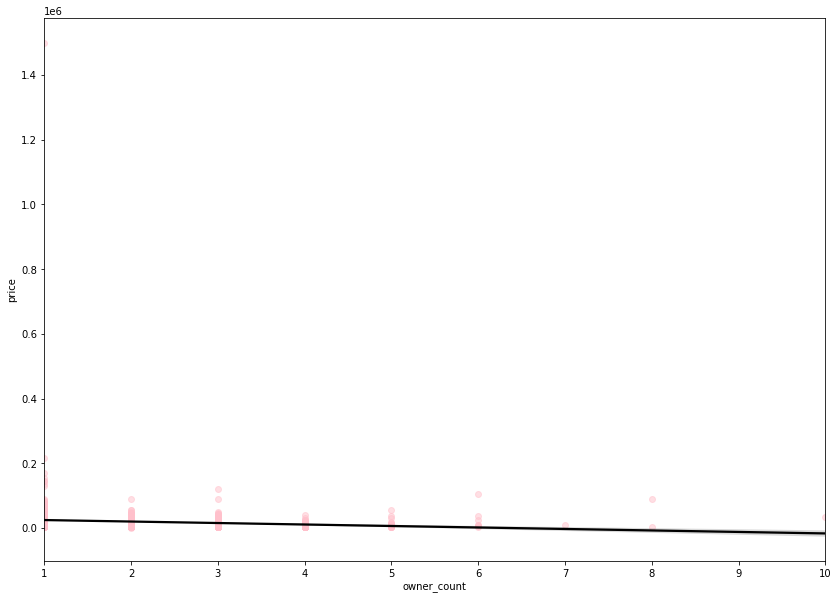

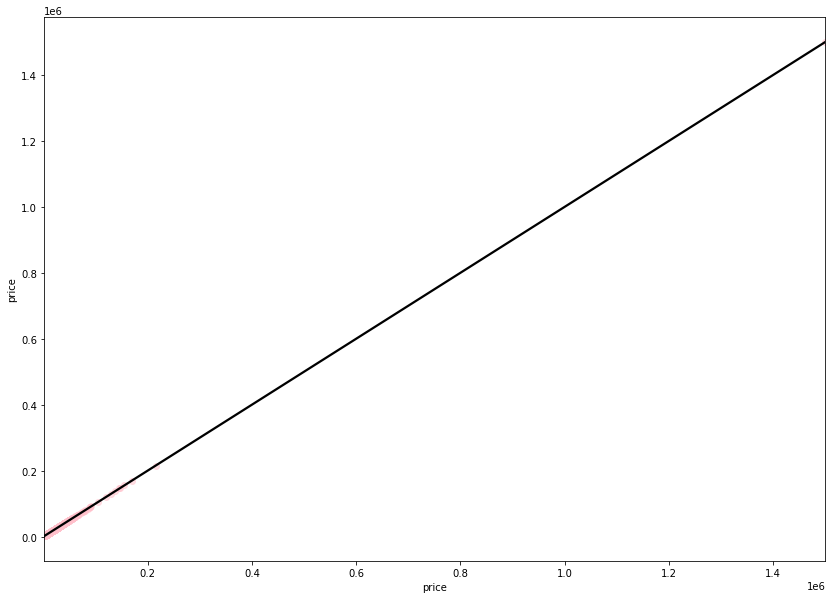

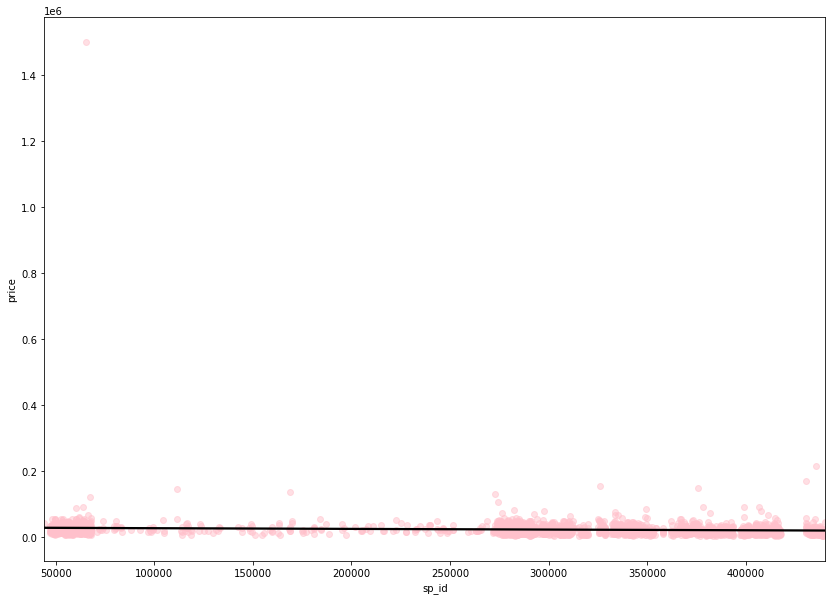

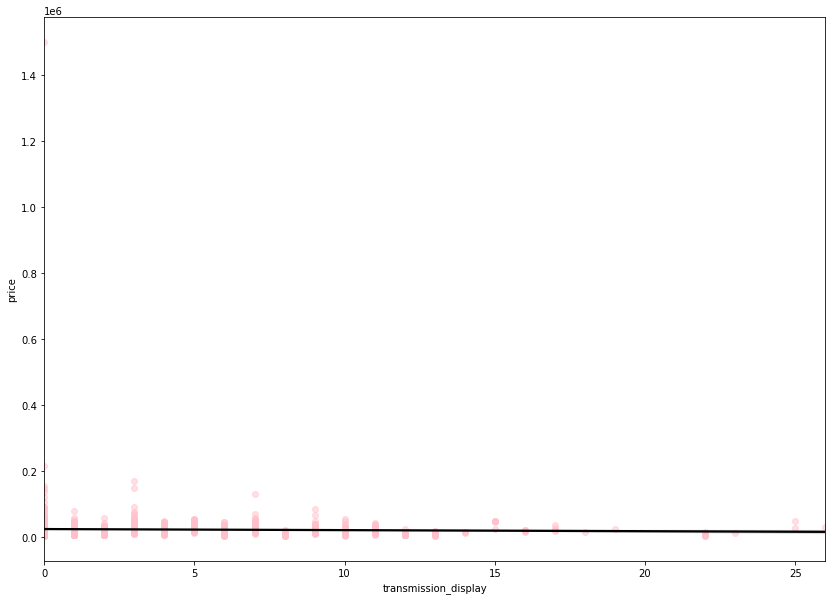

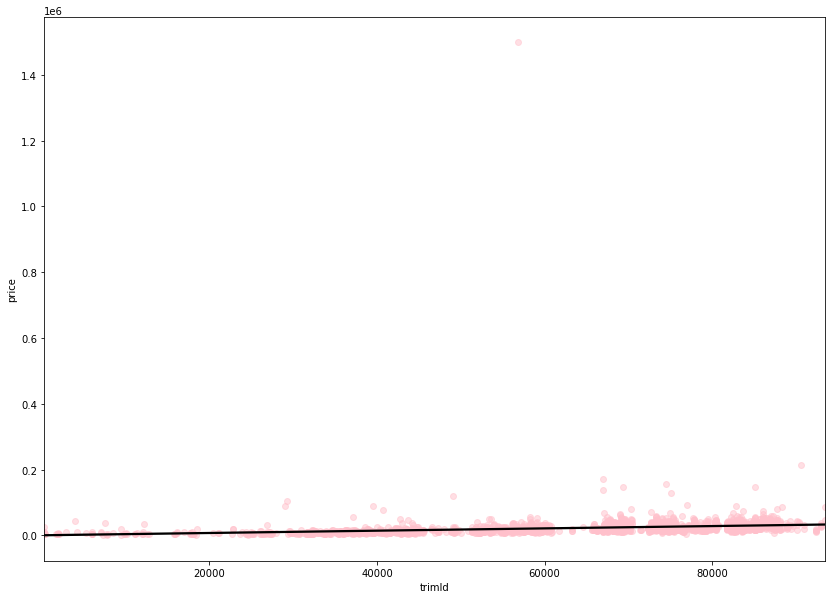

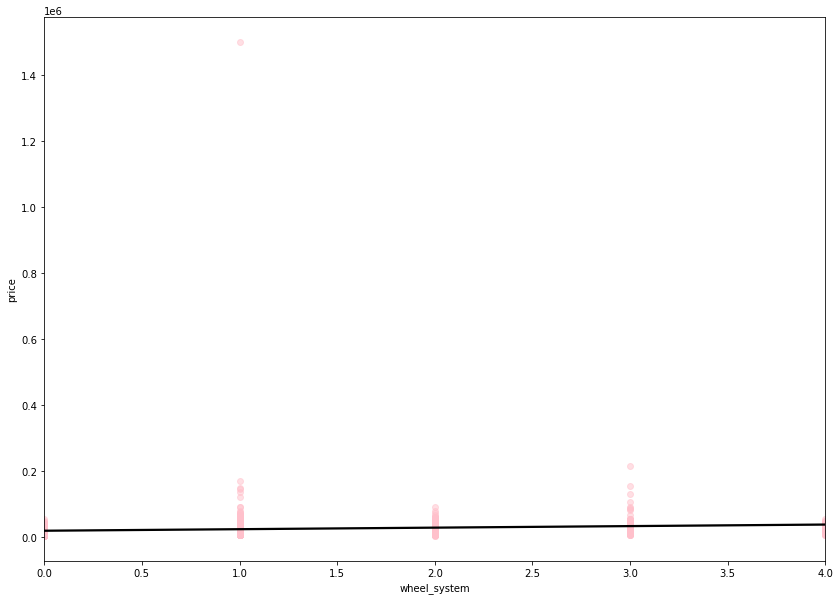

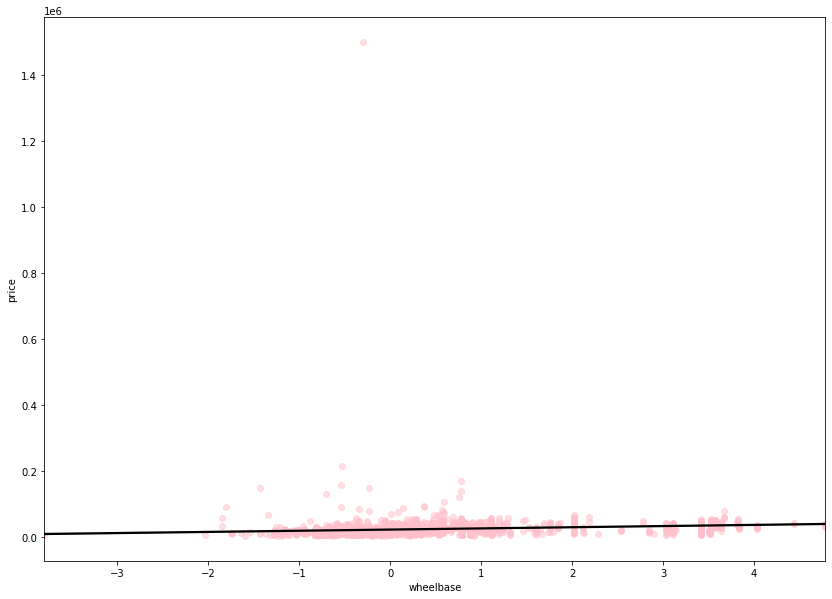

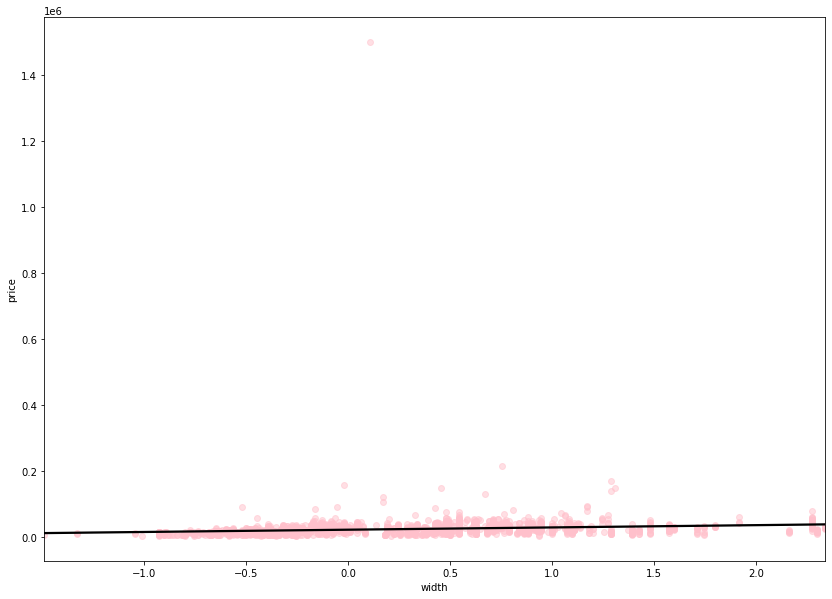

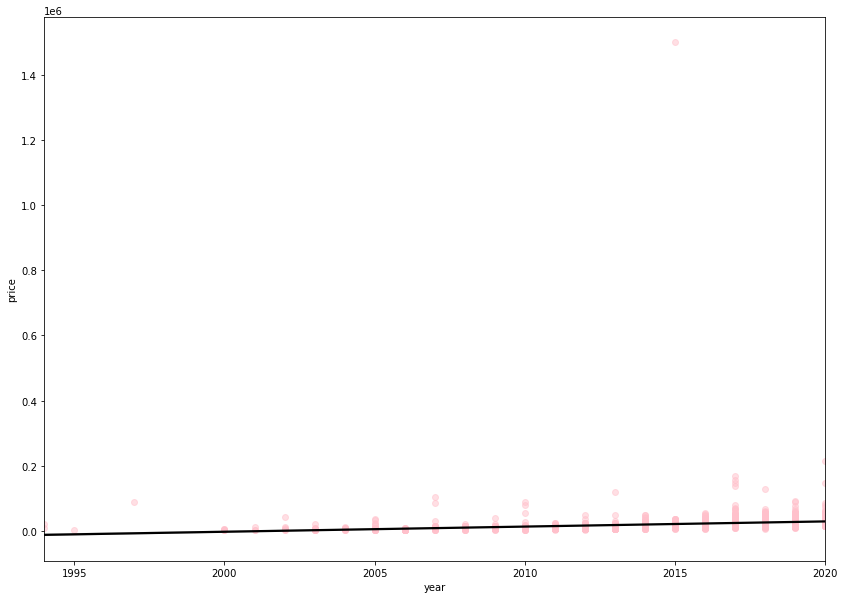

In [8]:
explore.graph_to_target(train_scaled.sample(2500).drop(columns=['vin','city','dealer_zip']),'price')

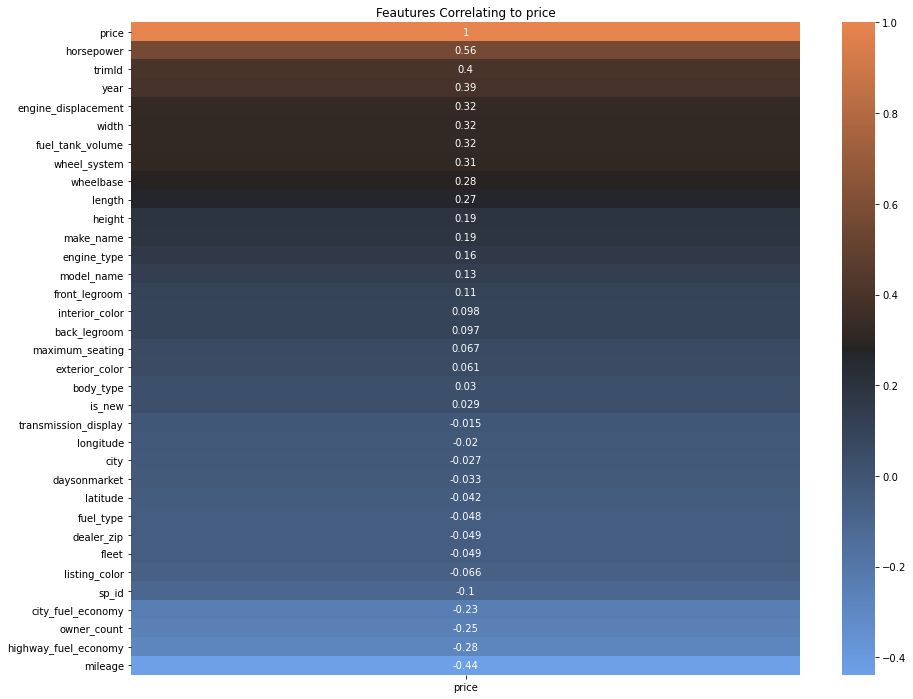

<AxesSubplot:title={'center':'Feautures Correlating to price'}>

In [9]:
explore.get_heatmap(train_scaled, 'price')

### Takeaways
- mostly right tailed, as theres more cars that are least expensive the luxury cars
- Year is left tailed, as this data is scraped from car gurus , majority of the cars listed upon scraping are new listed vehicles for sale
- Based on research, we want to use year, make and model of the car,trim level and milage on the user end in order to get the other factors that are needed for helping predict the car price. The minimum the user should know is the year make and model if the user knows the trim level then that gives us an idea on other useful information that can be used in our model and mileage (such as engine type, or horsepower)

### Statistical testing
Lets make sure Year, Make, and Model hold correlation to price, then we'll look at what rfe to see what else plays a role in predicting car prices. many of our variables are not normally distributed, so we'll use pearsons r correlation 

In [10]:
cont_var = ['year', 'mileage']
cat_var = ['make_name', 'model_name']
evaluate.get_t_test(cat_var, train_scaled, 'price', 0.05)
evaluate.get_pearsons(cont_var,'price',0.05,train_scaled)

Null Hypothesis: make_name has no correlation to price
Alternative hypothesis:  make_name has correlation to price 
p value 0.0 is less than alpha 0.05 , we reject our null hypothesis
-------------------------------------
Null Hypothesis: model_name has no correlation to price
Alternative hypothesis:  model_name has correlation to price 
p value 0.0 is less than alpha 0.05 , we reject our null hypothesis
-------------------------------------
Null Hypothesis: there is not linear correlation between year and price 
Alternative hypothesis:  year has linear correlation  to price 
p value 0.0 is less than alpha 0.05 , we reject our null hypothesis
-------------------------------------
Null Hypothesis: there is not linear correlation between mileage and price 
Alternative hypothesis:  mileage has linear correlation  to price 
p value 0.0 is less than alpha 0.05 , we reject our null hypothesis
-------------------------------------


### Feature Elimination
- What feautures does k-best and rfe select as the best drivers

In [11]:
X_train = train_scaled.drop(columns=['vin','price'])
y_train = train.price

X_validate = validate_scaled.drop(columns=['vin','price'])
y_validate = validate_scaled.price

X_test = test_scaled.drop(columns=['vin','price'])
y_test = test_scaled.price

In [12]:
kbest = evaluate.select_kbest(X_train, y_train, 10)

In [13]:
kbest

['engine_displacement',
 'fuel_tank_volume',
 'highway_fuel_economy',
 'horsepower',
 'mileage',
 'trimId',
 'wheel_system',
 'wheelbase',
 'width',
 'year']

In [14]:
rfe = evaluate.select_rfe(X_train, y_train, 10)

In [15]:
rfe

['city_fuel_economy',
 'engine_displacement',
 'frame_damaged',
 'franchise_dealer',
 'fuel_tank_volume',
 'highway_fuel_economy',
 'horsepower',
 'is_new',
 'mileage',
 'width']

##### We will use the Year, Make , Model, Mileage, Trimid as input from the user, then after having this information , grabbing the avg horsepower and avg city fuel economy , and most occuring wheel system for said car based off information in the dataset.


In [16]:
my_list = ['year', 'make_name', 'model_name', 'mileage', 'trimId', 'horsepower', 'city_fuel_economy', 'wheel_system']

# Modeling

### Baseline

In [17]:
target = 'price'

In [18]:
baseline = evaluate.baseline_errors(y_train)[2]

In [19]:
baseline

16018.715750265706

### OLS 

In [20]:
ols_train = evaluate.get_model_results(X_train[my_list], y_train, X_train[my_list], y_train, target)  

r2 Score:  0.5303144131137172
RMSE Score: 10978.204377071874


In [21]:
ols_validate = evaluate.get_model_results(X_train[my_list], y_train, X_validate[my_list], y_validate, target)  

r2 Score:  0.5790691065469589
RMSE Score: 9810.286619246517


### Lasso Lars 

In [22]:
lasso_train = evaluate.get_model_results(X_train[my_list], y_train, X_train[my_list], y_train, target,model='lasso', alpha= .01 )  

r2 Score:  0.5296817519140579
RMSE Score: 10978.21004521381


In [23]:
lasso_validate = evaluate.get_model_results(X_train[my_list], y_train, X_validate[my_list], y_validate, target,model='lasso', alpha= .01 )  

r2 Score:  0.5783712218156175
RMSE Score: 9810.414130407018


### Tweedie Regressor (GLM)

In [24]:
glm_train  = evaluate.get_model_results(X_train[my_list], y_train, X_train[my_list], y_train, target,model='glm', power = 1)  

r2 Score:  5.157805246777425e-32
RMSE Score: 16018.715750265706


In [25]:
glm_validate = evaluate.get_model_results(X_train[my_list], y_train, X_validate[my_list], y_validate, target,model='glm', power = 1)  

r2 Score:  2.5563552534811816e-06
RMSE Score: 15297.346686753728


### Polynomial Regression

In [26]:
poly_train = evaluate.get_model_results(X_train[my_list], y_train, X_train[my_list], y_train, target,model='poly', degree = 3)

r2 Score:  0.7826932730000534
RMSE Score: 7467.3117044630235


In [27]:
poly_validate = evaluate.get_model_results(X_train[my_list], y_train, X_validate[my_list], y_validate, target,model='poly', degree = 3)

r2 Score:  0.8650010410882026
RMSE Score: 6883.647973782738


#### Test on 3rd degree polynomial


In [28]:
poly_test = evaluate.get_model_results(X_train[my_list], y_train, X_test[my_list], y_test, target,model='poly', degree = 3)

r2 Score:  0.8744087025394656
RMSE Score: 6891.584243856776


In [30]:
train[train['price'] > 100000]

,vin,back_legroom,body_type,city,city_fuel_economy,daysonmarket,dealer_zip,engine_displacement,engine_type,exterior_color,...,model_name,owner_count,price,sp_id,transmission_display,trimId,wheel_system,wheelbase,width,year
351238,WP0AC29997S792687,31.7,5,2095,15.0,230,5636,3600.0,12,775,...,145,3.0,113990.0,401506.0,9,26890,3,92.7,71.2,2007
121293,SCFSMGAW6KGN01480,31.7,5,306,18.0,2,457,4000.0,2,7,...,663,2.0,124777.0,400600.0,0,77072,3,106.5,84.8,2019
321595,SBM13GAA3HW001929,31.7,5,213,16.0,37,545,3800.0,2,0,...,724,1.0,156885.0,415666.0,25,70125,3,105.1,82.5,2017
243224,WP0AF2A95KS164802,31.7,5,3,15.0,124,1862,4000.0,12,42,...,145,1.0,189900.0,363923.0,0,83059,3,96.6,77.9,2019
388518,ZHWGU22T56LA03693,30.6,7,83,10.0,139,695,5000.0,18,6559,...,521,3.0,100651.0,375095.0,9,26777,1,100.8,74.8,2006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320965,WP0AE2A97JS185166,31.7,5,1730,15.0,227,4945,3800.0,12,775,...,145,1.0,349000.0,67637.0,0,75661,3,96.5,77.9,2018
104147,WDDXK7KBXHA027606,30.6,7,851,14.0,86,8128,6000.0,15,25,...,356,2.0,249990.0,338623.0,7,70246,3,115.9,83.0,2017
478984,WUA4BCFX0L7901000,30.6,7,64,13.0,15,3232,5200.0,18,908,...,370,1.0,193777.0,294519.0,7,84797,1,104.4,80.2,2020
94072,ZHWGU22TX8LA07290,30.6,7,10,10.0,141,3004,5000.0,18,119,...,521,1.0,119995.0,342789.0,10,33534,1,100.8,74.8,2008
